<a id='menu'></a>
### MEJORAMIENTO DE LA CALIDAD DE LOS DATOS

##### [1. Cálculo de la calidad de los datos de los nodos](#section1)
##### 1. Cálculo de la correlación de los datos de los sensores DF y NOVA del nodo como indicador de la presencia de outliers
##### [2. Proceso de detección de Outliers mediante el algoritmo de Autoencoder](#section2)
##### [3. Corrección de los Outliers por el mecanismo de tendencia](#section3)
##### [4. Aplicación de DataFusión entre los datos de los sensores DF y Nova de cada nodo](#section4)
##### 5. Interpolación del dato en ubicación dada mediante la técnica de Kriging, usando los datos fusionados

### IMPORTACIÓN DE DATOS

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import funciones_FS as f_FS
import funciones_TS as f_TS
import funciones_OC as f_OC
import DQM as f_DQM
import funciones_DF as f_DF
import warnings
import importlib
import math

# Ignore the warning, can comment this 
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None  # default='warn' --- Para quitar los warnings de pandas y python
#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # Quitar warnings tensorflow
pd.set_option("display.precision", 4)  # Todos los valores de los dataframe de pandas tendrán 4 decimales


ruta = "F:/PhD/Datos SIATA/Análisis/Descriptivo/Datos/"
#archivo = "DF"
#sensor = "pm25"
redondeo = 4
df_CS = pd.read_csv(ruta+"datosCoordenados_CS.csv",sep=",")
df_SIATA = pd.read_csv(ruta+"datosCoordenados_SIATA.csv",sep=",")
entreno = pd.read_csv(ruta+"nodos_entrenamiento.csv",sep=",")
#datos = pd.read_csv(ruta+"test_"+archivo+"_outliers_N.csv",sep=",")

#variables = ['pm25']#,'humedad_relativa', 'temperatura'
#for sensor in variables:
#    datos[sensor] = pd.Series([round(val,redondeo) for val in datos[sensor]])
#    entreno[sensor] = pd.Series([round(val,redondeo) for val in entreno[sensor]])

#print("cantidad de datos de test: ", len(datos))

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [ ]:
df_SIATA.codigoSerial.unique()

In [ ]:
importlib.reload(f_FS)
# PASO DE DATAFRAME POR MINUTOS A DATAFRAME POR HORAS 
#CS_x_hora = f_FS.datos_x_hora(df_CS, 'pm25_df')
#CS_x_hora.head(5)
datos_SIATA = f_FS.extrac_data_SIATA(df_SIATA, estacionSIATA, year, mes, dias)

In [ ]:
#header_CC=["codigoSerial", "fecha", "hora", "fechaHora", "temperatura", "humedad_relativa", "pm1_df", "pm10_df", "pm25_df", "pm1_nova", "pm10_nova", "pm25_nova", "calidad_temperatura", "calidad_humedad_relativa", "calidad_pm1_df", "calidad_pm10_df", "calidad_pm25_df", "calidad_pm1_nova", "calidad_pm10_nova", "calidad_pm25_nova"]
#df_SC = pd.read_csv("F:/PhD/Datos SIATA/Julio/February.csv",sep=",", header=None, names=header_CC)

#filtro = df_SC[["codigoSerial", "fechaHora", "pm25_df", "pm25_nova"]]
#filtro = filtro[filtro['codigoSerial'].isin(nodosCS)]
for i in nodosCS:
    res = filtro[filtro['codigoSerial'] == i]
    print(i, 'DF', res[res['pm25_df'] < 0]['pm25_df'].count())


# df_window.loc[df_window["pm25_nova"]>999,"pm25_nova"]=np.nan
# df_window.loc[df_window["pm25_nova"]<0,"pm25_nova"]=np.nan
# df_window.loc[df_window["pm25_df"]>999,"pm25_df"]=np.nan
# df_window.loc[df_window["pm25_df"]<0,"pm25_df"]=np.nan



<a id='section1'></a>
### [1. MEDICIÓN DE LA CALIDAD DE LOS DATOS](#menu)

In [11]:
importlib.reload(f_DQM)
importlib.reload(f_FS)

# Fecha del análisis
year = '2020'
mes = '02'
dias = 29

# Estación SIATA de referencia
estacionSIATA = 80
cercania = 2  # En Kms

#Extracción de los datos del nodo SIATA
datos_SIATA = f_FS.extrac_data_SIATA(df_SIATA, estacionSIATA, year, mes, dias)

#Limpieza datos SIATA
datos_SIATA.loc[datos_SIATA['pm25']>999,'pm25']=np.nan
datos_SIATA.loc[datos_SIATA['pm25']<0,'pm25']=np.nan

# Extracción de los datos de los nodos CS de acuerdo con la estación SIATA seleccionada
fusion, nodosCS = f_FS.extrac_data_CS(df_CS, datos_SIATA, cercania, estacionSIATA, year, mes, dias)
nodosEntreno = entreno.codigoSerial.unique().tolist()

# PASO DE DATAFRAME POR MINUTOS A DATAFRAME POR HORAS 
datos_h = f_FS.datos_x_hora(fusion, ['pm25_df', 'pm25_nova'], nodosCS)

# Creación del dataframe para almacenar las medidas de calidad de los datos
dq_measure_CS_first = pd.DataFrame()
dq_measure_Entreno = pd.DataFrame()

# Cálculo de la completitud
dq_measure_CS_first, com_detallado = f_DQM.completitud(fusion, nodosCS, dq_measure_CS_first, debug = 'N')
dq_measure_Entreno = f_DQM.completitud(entreno, nodosEntreno, dq_measure_Entreno, debug = 'N')

# Cálculo de la incertidumbre
dq_measure_CS_first = f_DQM.incertidumbre(fusion, nodosCS, dq_measure_CS_first, debug = 'N')
#dq_measure_CS_first = f_DQM.incertidumbre2(fusion, datos_SIATA, nodosCS, dq_measure_CS_first, debug = 'N')
dq_measure_Entreno = f_DQM.incertidumbre(entreno, nodosEntreno, dq_measure_Entreno, debug = 'N')

# Cálculo de la precisión
dq_measure_CS_first, prec_detallado = f_DQM.precision(fusion, nodosCS, dq_measure_CS_first, debug = 'N')
dq_measure_Entreno = f_DQM.precision(entreno, nodosEntreno, dq_measure_Entreno, debug = 'N')

# Cálculo de accuracy
dq_measure_CS_first, acc_detallado = f_DQM.accuracy(datos_SIATA, fusion, nodosCS, dq_measure_CS_first, debug = 'N')

# Cálculo de la correlación
dq_measure_CS_first, corr_detallado = f_DQM.correlacion(fusion, nodosCS, dq_measure_CS_first, debug = 'N')
#dq_measure_CS_first, corr_detallado = f_DQM.correlacion(fusion, datos_SIATA, nodosCS, dq_measure_CS_first, debug = 'N')
#dq_measure_Entreno, corr_detallado = f_DQM.correlacion(entreno, nodosEntreno, dq_measure_Entreno, debug = 'N')

# Cálculo del DQ Index
dq_measure_CS_first, nodosCS = f_DQM.DQ_Index2(dq_measure_CS_first)

dq_measure_CS_first


SIATA: 80.0 CS 1 distancia 1.0377151891270973
SIATA: 80.0 CS 119 distancia 1.9679516382245976
SIATA: 80.0 CS 140 distancia 0.2775208241732859
SIATA: 80.0 CS 149 distancia 1.182301027855984
SIATA: 80.0 CS 171 distancia 1.5307643575447818
SIATA: 80.0 CS 211 distancia 1.554637685923479
SIATA: 80.0 CS 231 distancia 0.8567832670673802
SIATA: 80.0 CS 238 distancia 0.6848302999474621
completitud: pm25_df pm25_nova
completitud: pm25_df pm25_nova
incertidumbre: pm25_df pm25_nova
incertidumbre: pm25_df pm25_nova
precision: pm25_df pm25_nova
precision: pm25_df pm25_nova
exactitud: pm25_df pm25_nova
correlacion: pm25_df pm25_nova


,comp_df,comp_nova,uncer,prec_df,prec_nova,accu_df,accu_nova,concord,DQ_Index_df,DQ_Index_nova,Codigo_EPA
1,0.9200,0.9200,0.5638,0.5906,0.0000,0.6449,0.5217,0.0774,0.5654,0.4677,CU
119,0.4009,0.4009,0.8530,0.5487,0.4443,0.6335,0.6514,0.6754,0.6364,0.6348,U
140,0.7947,0.7947,0.7685,0.6202,0.3421,0.7666,0.6824,0.3513,0.6831,0.6266,CU
149,0.8940,0.8940,0.8532,0.6012,0.4750,0.6059,0.5822,0.6209,0.6978,0.6780,CU
171,0.5053,0.5053,0.6583,0.6279,0.0180,0.7025,0.5980,0.0644,0.5402,0.4482,U
211,0.9254,0.9254,0.9502,0.4714,0.4275,0.6228,0.6176,0.9697,0.7800,0.7743,CU
231,0.7565,0.7565,0.9024,0.5980,0.5469,0.6870,0.5450,0.9642,0.7798,0.7191,CU
238,0.0088,0.0088,0.9352,0.7613,0.8231,0.7860,0.7591,0.8312,0.6957,0.6901,U


In [21]:
### EXTRAER LOS DATOS DE UN NODO Y EXPORTARLOS A UN TXT ---> PARA LEER EN C
nodo = 211
pm25 = fusion.loc[fusion.loc[:,"codigoSerial"] == int(nodo)]
with open('datos.txt','w') as f:
    for i in pm25['pm25_df']:
        f.write(str(round(i,5)))
        f.write('\n')

<Axes: >

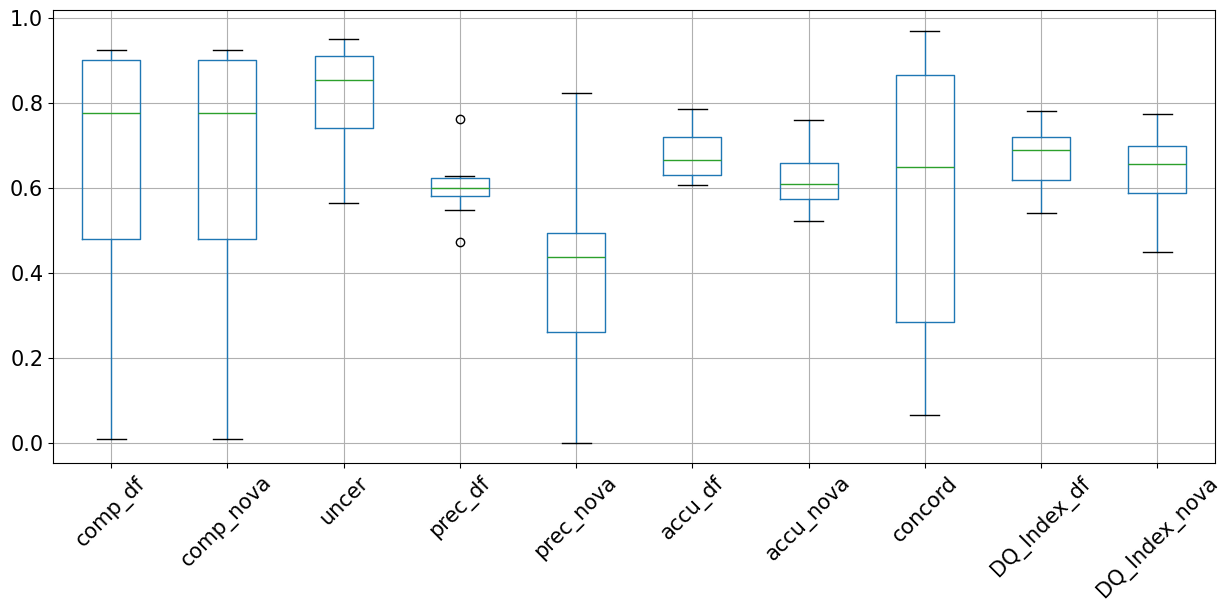

In [380]:
dq_measure_CS_first.iloc[:,:10].boxplot(figsize=(15,6),fontsize=15, rot=45)

In [ ]:
# DEFAULT COLORS OF MATPLIOTLIB IN ORDES OF USE
# ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

DQ_nodes = {}

j=0
PLOTS_PER_ROW = 4
nrows = math.ceil((len(dq_measure_CS_first)*2)/PLOTS_PER_ROW)
plt.figure(figsize=(20, 20), dpi=100)
plt.subplots_adjust(hspace=0.2, wspace=0.5)
plt.suptitle("Metrics of dimensions per citizen scientist node", fontsize=20, y=0.95)

for nodo in dq_measure_CS_first.index:
    DQ_sensor = {}
    for sensor in ['df','nova']:
        DQ_dim = {}
        for c in dq_measure_CS_first.columns[:8]:
            c1 = c.split('_')
            if 'df'in c1 or 'nova' in c1:
                if sensor in c1:
                    DQ_dim[c1[0]] = dq_measure_CS_first.loc[nodo][c]
            else:
                DQ_dim[c1[0]] = dq_measure_CS_first.loc[nodo][c]

        
        DQ_sensor[sensor] = DQ_dim

        dims = list(DQ_dim.keys())
        dims = [*dims, dims[0]]

        scores = list(DQ_dim.values())
        scores = [*scores, scores[0]]

        label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(dims))

        axs = plt.subplot(nrows, PLOTS_PER_ROW, j+1, polar=True)
        
        axs.plot(label_loc, scores, 'o-')
        axs.set_title('Node '+str(nodo)+' '+str(sensor).upper(), size=15)
        plt.thetagrids(np.degrees(label_loc), labels=dims)
        axs.fill(label_loc, scores, alpha=0.25)
        j+=1
    
    DQ_nodes[str(nodo)] = DQ_sensor

#plt.savefig("dimensions-metrics.svg", dpi=200, bbox_inches='tight')
#plt.show()        
        

In [ ]:
print(dims)

In [ ]:
data = np.array([[1.0, 5.0, 5.0, 3.0, 1.0, 0.3, 5.0, 1.0],
                 [0.2, 1.0, 0.2, 0.3, 1.0, 0.3, 5.0, 1.0],
                 [0.2, 5.0, 1.0, 1.0, 1.0, 3.0, 7.0, 1.0],
                 [0.3, 3.0, 1.0, 1.0, 0.3, 1.0, 3.0, 1.0],
                 [1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 5.0, 0.2],
                 [3.0, 3.0, 0.3, 1.0, 1.0, 1.0, 7.0, 1.0],
                 [0.2, 0.2, 0.1, 0.3, 0.2, 0.1, 1.0, 0.2],
                 [1.0, 1.0, 1.0, 1.0, 5.0, 1.0, 5.0, 1.0]])

variables = ['accu', 'prec', 'uncer', 'comp', 'time', 'volum', 'redund', 'concord']

pwM = pd.DataFrame(data, columns=variables, index=variables)



######  PARA EL ARTÍCULO SE DEJAN SOLO ACCURACY, PRECISION, COMPLETENESS, CONCORDANCE Y CONFIDENCE COMO OBJETIVO DE LA UNCERTAINTY ################

pwM.drop(['time', 'volum', 'redund'], axis=1, inplace=True)
pwM.drop(['time', 'volum', 'redund'], axis=0, inplace=True)

pwMNor =pd.DataFrame(columns=pwM.columns, index=pwM.index) 

for i in pwM.columns:
    for j in pwM.index:
        pwMNor.loc[i,j] = pwM.loc[i,j]/pwM.loc[:,j].sum()

weights = {}

for i in pwMNor.index:
    weights[i] = pwMNor.loc[i,:].mean()

print('***************DQ Index de los nodos***************')
for n in DQ_nodes.keys():
    for s in DQ_nodes[n].keys():
        DQ_index = 0
        for d in DQ_nodes[n][s].keys():
            #print(n,s,d, DQ_nodes[n][s][d], weights[d])
            DQ_index += DQ_nodes[n][s][d]*weights[d]
 
        print(n,s, round(DQ_index,2))
    




In [ ]:
dq_measure_CS_first = backup.copy()

In [ ]:
importlib.reload(f_DQM)
#dq_measure_CS, nodosCS = f_DQM.DQ_Index(dq_measure_CS)
dq_measure_CS_first, nodosCS = f_DQM.DQ_Index2(dq_measure_CS_first)
#nodosCS = dq_measure_CS[dq_measure_CS['Codigo_EPA'].str.contains('C')].index.tolist()
dq_measure_CS_first

In [ ]:
nodosCS = dq_measure_CS.loc[dq_measure_CS['DQ_Index'] > 0.7].index.tolist()

In [ ]:
importlib.reload(f_DQM)

f_DQM.filtro(com_detallado,1,'xdia',23)


In [ ]:
fusion['2020-02-18']['pm25_df'].plot()
datos_SIATA['2020-02-18']['pm25'].plot()

In [ ]:
import seaborn as sns

sns.heatmap(dq_measure_CS.corr(), annot=True, fmt=".2f")

In [ ]:
fusion.loc[fusion.loc[:,'codigoSerial'] == 1][['pm25_nova','pm25_df']].plot()
#datos[['pm25_df','pm25_nova']]


In [ ]:
# Ajuste en la fórmula de la incertidumbre

import random
lista1 = [random.randint(30,35) for _ in range(40)]
lista2 = [random.randint(10,2000) for _ in range(40)]
datafr = pd.DataFrame(list(zip(lista1,lista2)), columns=['lista1','lista2'])

datafr.plot()

print(np.sqrt(((datafr['lista1']-datafr['lista2']).pow(2).sum())/(2*len(datafr)*((datafr['lista1']+datafr['lista2']).mean())**2)))
np.sqrt((datafr['lista1']-datafr['lista2']).pow(2).mean()/2)/((datafr['lista1']-datafr['lista2']).mean()/2)

PROPUESTA DE ELECCIÓN DE OUTLIERS
1. Completitud: (Eliminatorio) Si un nodo tiene baja completitud quiere decir que hay muchos datos faltantes, lo que llevaría a la necesidad de recuperar los datos faltantes o realizar modelos sin estos datos. Ambos casos son negativos dado que si se recuperan los datos faltantes, el dataset quedaría con un alto nivel de datos sintéticos, lo que provocaría poca confiabilidad en los modelos generados por estos datos. Y si se usan los datos con esos faltantes, los modelos podrían no reflejar la realidad de la variable. Se propone un nivel de completitud mínima del 85% para ser considerado. Por qué un 85%?, porque eso representaría la ausensia de 5 días de datos en un mes, dias que podrían ser cubiertos por otros sensores, o incluso por el mismo sensor en otras semanas.
2. Incertidumbre: (Clasificarotorio) La incertidumbre es represnetación de la combinación de la precisión y la exactitud, abarca dos dimensiones adicionales. Pornderación del 50%
3. Precisión: (Clasificarotorio) Es la medición de la disperción que tiene los datos. Una baja precisión indica que los datos están muy dispersos, es decir, hubo mucho ruido externo o los equipos están poco calibrados. Es un indicador de posible presencia de outliers. Ponderación del 25%
4. exactitud: (Clasificarotorio) Es la medición de lo cerca que está el valor obtenido de un valor esperado. Si se presenta una baja exactitud, indica que hay un posible evento de larga duración o permanente que está desplazando los datos.  Ponderación del 25%

En un contexto de la medición de la calidad del aire, la ausensia de datos podría ser cubierta mediante predicción dadda la característica estacional de la variable, sin embargo, una ausensia muy grande de datos podría generar un comportamiento muy diferente al normal de esta variable.

Por otro lado, tener datos con una alta incertidumbre en este contexto provoca modelos alejados de la realidad, es decir, modelos no útiles. Mienstras que una baja precisión y baja exactitud provoca modelos que podrían ser suceptibles de corrección si se logra identificar la razón del error del modelo.



In [ ]:
df = dq_measure_CS.copy()
df = df.loc[df.comp_df > 0.75]
#nodos = (1-df.incert)*(1/3) + df.prec_df*(1/3) + df.accu_df*(1/3)
nodos = (1-df.incert)*0.5 + df.prec_df*0.25 + df.exac_df*0.25

nodosCS = nodos.loc[nodos > 0.6].index.tolist()
nodosCS, nodos


In [ ]:
importlib.reload(f_FS)
# PASO DE DATAFRAME POR MINUTOS A DATAFRAME POR HORAS 
fusion = f_FS.datos_x_hora(fusion, ['pm25_df', 'pm25_nova'], nodosCS)

<a id='section2'></a>
### [2. DETECCIÓN DE OUTLIERS](#menu)

In [6]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import layers
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
#from keras.utils.vis_utils import plot_model
from datetime import datetime
import seaborn as sns

import funciones_OD as f_OD
import funciones_Autoencoder as f_Auto


In [7]:
importlib.reload(f_Auto)
importlib.reload(f_DQM)

TIME_STEP = 1

for variable in ['pm25_df', 'pm25_nova']:
        sensor = variable.split('_')[1]
        # Entrenamiento
        globals()['model_'+sensor], globals()['history_'+sensor], globals()['x_train_'+sensor], globals()['training_mean_'+sensor], globals()['training_std_'+sensor] = f_Auto.entrenamiento(entreno, variable, TIME_STEP, graficos='N', debug='N')
        #globals()['model_'+sensor], history, x_train, training_mean, training_std = f_Auto.entrenamiento(entreno, variable, TIME_STEP, graficos='N', debug='N')

        # Cálculo de threshold
        globals()['threshold_'+sensor], globals()['x_train_pred_'+sensor] = f_Auto.umbral(eval('model_'+sensor), eval('x_train_'+sensor), graficos='N', debug='N')

        # Chequeo de entrenamiento
        f_Auto.learn_check(eval('x_train_pred_'+sensor), eval('x_train_'+sensor), graficos='N')



4506/4506 [==============================] - 12s 3ms/step


In [8]:

outliers_detected = {}
nodos_outliers = []
for nube in nodosCS:
    datos_nube = fusion.loc[fusion.loc[:,'codigoSerial'] == nube]
    #datos_nube = datos_m.loc[datos_m.loc[:,'codigoSerial'] == nube]
    #datos_nube.reset_index(inplace=True, drop=True)
    
    anomalias = {}
    
    for variable in ['pm25_df', 'pm25_nova']:
        sensor = variable.split('_')[1]
        print('Nube:',nube, ' Variable:', variable)
        # # Entrenamiento
        # model, history, x_train, training_mean, training_std = f_Auto.entrenamiento(entreno, variable, TIME_STEP, graficos='N', debug='N')

        # # Cálculo de threshold
        # threshold, x_train_pred = f_Auto.umbral(model, x_train, graficos='N', debug='N')

        # # Chequeo de entrenamiento
        # f_Auto.learn_check(x_train_pred, x_train, graficos='N')
        
        # Detección
        anomalies = f_Auto.deteccion(datos_nube, variable, eval('model_'+sensor), eval('training_mean_'+sensor), eval('training_std_'+sensor), eval('threshold_'+sensor), TIME_STEP, graficos='N', debug='N')

        # Gráfico de la detección
        #f_Auto.graf_deteccion(datos_nube, variable, anomalies, 300)

        if len(anomalies) > 0:
            anomalias[variable] = anomalies
            print(len(anomalies), 'Outliers detectados')

        #del model, history
    
    if len(anomalias) > 0:
        outliers_detected[nube] = anomalias

dq_measure_CS_first = f_DQM.outliers(fusion, outliers_detected, dq_measure_CS_first)

Nube: 1  Variable: pm25_df
1305/1305 [==============================] - 2s 2ms/step
37 Outliers detectados
Nube: 1  Variable: pm25_nova
1305/1305 [==============================] - 4s 3ms/step
649 Outliers detectados
Nube: 140  Variable: pm25_df
1305/1305 [==============================] - 4s 3ms/step
2 Outliers detectados
Nube: 140  Variable: pm25_nova
1305/1305 [==============================] - 3s 3ms/step
205 Outliers detectados
Nube: 149  Variable: pm25_df
1305/1305 [==============================] - 3s 2ms/step
18 Outliers detectados
Nube: 149  Variable: pm25_nova
1305/1305 [==============================] - 4s 3ms/step
284 Outliers detectados
Nube: 211  Variable: pm25_df
1305/1305 [==============================] - 4s 3ms/step
37 Outliers detectados
Nube: 211  Variable: pm25_nova
1305/1305 [==============================] - 3s 2ms/step
59 Outliers detectados
Nube: 231  Variable: pm25_df
1305/1305 [==============================] - 3s 2ms/step
5 Outliers detectados
Nube: 231  Var

In [9]:
dq_measure_CS_first

,comp_df,comp_nova,uncer,prec_df,prec_nova,accu_df,accu_nova,concord,DQ_Index_df,DQ_Index_nova,Codigo_EPA,cant,outl_df,outl_df_%,outl_nova,outl_nova_%
1,0.9200,0.9200,0.5638,0.5906,0.0000,0.6449,0.5217,0.0774,0.5654,0.4677,CU,38418.0,37.0,9.6309e-04,649.0,0.0169
119,0.4009,0.4009,0.8530,0.5487,0.4443,0.6335,0.6514,0.6754,0.6364,0.6348,U,NaN,NaN,NaN,NaN,NaN
140,0.7947,0.7947,0.7685,0.6202,0.3421,0.7666,0.6824,0.3513,0.6831,0.6266,CU,33188.0,2.0,6.0263e-05,205.0,0.0062
149,0.8940,0.8940,0.8532,0.6012,0.4750,0.6059,0.5822,0.6209,0.6978,0.6780,CU,37334.0,18.0,4.8213e-04,284.0,0.0076
171,0.5053,0.5053,0.6583,0.6279,0.0180,0.7025,0.5980,0.0644,0.5402,0.4482,U,NaN,NaN,NaN,NaN,NaN
211,0.9254,0.9254,0.9502,0.4714,0.4275,0.6228,0.6176,0.9697,0.7800,0.7743,CU,38644.0,37.0,9.5746e-04,59.0,0.0015
231,0.7565,0.7565,0.9024,0.5980,0.5469,0.6870,0.5450,0.9642,0.7798,0.7191,CU,31592.0,5.0,1.5827e-04,66.0,0.0021
238,0.0088,0.0088,0.9352,0.7613,0.8231,0.7860,0.7591,0.8312,0.6957,0.6901,U,NaN,NaN,NaN,NaN,NaN


In [ ]:
import funciones_OC as f_OC

importlib.reload(f_OC)

# Calculo de estadísticos de los datos por hora, dia y nodo.
entreno, estadisticos_df = f_OC.estacionalidad(entreno, 'pm25_df')

# Calculo de los estadísticos consolidados por hora de todos los nodos en todos los días.
#consolidado_df = f_OC.est_consol(estadisticos_df, 'media')

# Corrección del outlier por el método de ponderación.
#datos_corregidos = f_OC.corregir_ponderado(datos, outliers_detected)


# Media diaria por nodo por hora
'''
plt.figure(figsize=(13, 5), dpi=100)
for dia in graf.fecha.unique().tolist()[:3]:
    diario = graf.loc[graf.loc[:,'fecha'] == dia]
    diario.reset_index(inplace=True, drop=True)
    plt.plot(diario.hora, diario.media, label=str(dia))
    #plt.xticks(rotation=90)
    plt.legend(loc='upper center')
plt.show()'''

# Boxplot diaria por nodo por hora
fig = entreno.loc[entreno.loc[:,'codigoSerial'] == 50]
n = 15   #4, 6, 11, 15
for dia in ['2/16/2020']:#,'2/5/2020','2/12/2020', '2/7/2020']:#fig.fecha.unique().tolist()[n:n+1]: #['2/5/2020','2/7/2020','2/12/2020','2/16/2020']
    print(dia)
    diario = fig.loc[fig.loc[:,'fecha'] == dia]
    diario.reset_index(inplace=True, drop=True)
    boxplot = diario.boxplot(column=['pm25_df'], by='time', rot=0, figsize=(10, 4), )
    boxplot.set_title('Node 211, 2020-02-16, DF sensor')
    box = boxplot.get_figure()

    box.suptitle('')

    #plt.savefig("Node-211-2020-02-16.eps", dpi=200, bbox_inches='tight')   

<a id='section3'></a>
### [3. CORRECCIÓN DE OUTLIERS](#menu)

##### CORRECCIÓN POR EL MÉTODO DE DISTRIBUCIÓN DE PROBABILIDAD

In [10]:
import funciones_OC as f_OC
importlib.reload(f_OC)
import time

# iloc, loc, at, iat -> https://pyciencia.blogspot.com/2015/05/obtener-y-filtrar-datos-de-un-dataframe.html

# The PM2.5 concentration has high variability over time but manifests a daily periodic pattern. https://escholarship.org/uc/item/41z065nm
'''The observed PM2.5 concentration in a day usually reaches its lowest value around noon and starts climbing in 
the evening until it reaches its highest value in midnight.'''

nodos = list(outliers_detected.keys())
datos_d = pd.DataFrame()

for nube in nodos:
    datos_nube = fusion.loc[fusion.loc[:,'codigoSerial'] == nube]
    print('\n***** NODO', nube, '******')
    #datos_nube.reset_index(inplace=True, drop=True)
    datos_nube['Pred_df'] = datos_nube['pm25_df']
    datos_nube['Pred_nova'] = datos_nube['pm25_nova']
    datos_nube['Art_df'] = np.NaN
    datos_nube['Art_nova'] = np.NaN
    
    for variable in outliers_detected[nube].keys():     
        print('Sensor:',variable)
        sensor = variable.split('_')
        artifi = 'Art_'+sensor[1]
        sensor = 'Pred_'+sensor[1]
        #datos_nube[sensor] = datos_nube[variable]
        datos_nube[sensor].iloc[outliers_detected[nube][variable]] = np.nan
        #datos_nube[artifi] = np.NaN

        dist = pd.DataFrame()
        for i in range(24):
            filtro = datos_nube[datos_nube.index.hour == i][sensor]
            mejor = f_OC.check_function_scipy(filtro)
            dist = pd.concat([dist, pd.DataFrame(mejor).T], ignore_index=True)
            #dist = dist.append(mejor, ignore_index=True)

        cont = 1
        for outlier in outliers_detected[nube][variable]:
            datos_nube.iat[outlier, datos_nube.columns.get_loc(sensor)] = f_OC.corregir_probabilidad(datos_nube, outlier, sensor, dist)
            datos_nube.iat[outlier, datos_nube.columns.get_loc(artifi)] = 1
            #print(cont,'de',len(outliers_detected[nube][variable]), '-->',datetime.datetime.now().time())
            cont += 1
        
        #time.sleep(10)
    #print(datos_nube.head(3))
    datos_d = pd.concat([datos_d, datos_nube])

    # Verificar la integral de la función
    # Comparar la función de densidad entre antes de corregir y después de corregir
    # Hallar el mejor kernel para el ajuste de la función de densidad


***** NODO 1 ******
Sensor: pm25_df
Sensor: pm25_nova

***** NODO 140 ******
Sensor: pm25_df
Sensor: pm25_nova

***** NODO 149 ******
Sensor: pm25_df
Sensor: pm25_nova

***** NODO 211 ******
Sensor: pm25_df
Sensor: pm25_nova

***** NODO 231 ******
Sensor: pm25_df
Sensor: pm25_nova


<Axes: title={'center': 'Data correction for node 149, sensor Nova'}, xlabel='fechaHora'>

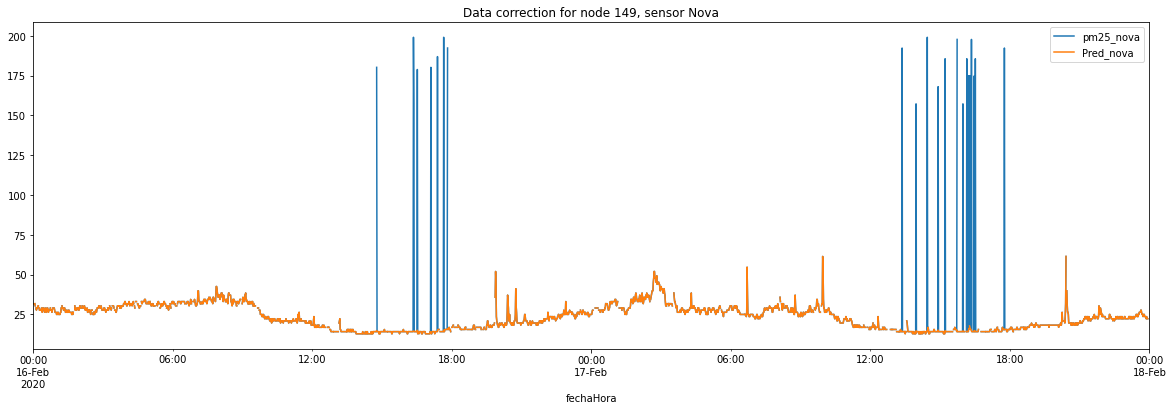

In [11]:
#datos_d[datos_d['codigoSerial'] == 140].loc['2020-02-06 12:00':'2020-02-06 18:00'][['pm25_nova', 'Pred_nova']].plot(figsize=(20,6))
datos_d[datos_d['codigoSerial'] == 149].loc['2020-02-16 00:00':'2020-02-18 00:00'][['pm25_nova', 'Pred_nova']].plot(figsize=(20,6), title=('Data correction for node 149, sensor Nova'))

In [12]:
importlib.reload(f_DQM)
datos_corregidos = datos_d.copy()
dq_measure_CS_correction = pd.DataFrame()

datos_corregidos.drop(['pm25_df', 'pm25_nova'], axis=1, inplace=True)
#datos_corregidos.rename(columns={'Pred_df':'pm25_df', 'Pred_nova':'pm25_nova'}, inplace=True)

# Cálculo de la completitud
dq_measure_CS_correction, com_detallado = f_DQM.completitud(datos_corregidos, nodos, dq_measure_CS_correction, debug = 'N')

# Cálculo de la incertidumbre
dq_measure_CS_correction = f_DQM.incertidumbre(datos_corregidos, nodos, dq_measure_CS_correction, debug = 'N')

# Cálculo de la precisión
dq_measure_CS_correction, prec_detallado = f_DQM.precision(datos_corregidos, nodos, dq_measure_CS_correction, debug = 'N')

# Cálculo de accuracy
dq_measure_CS_correction, acc_detallado = f_DQM.accuracy(datos_SIATA, datos_corregidos, nodos, dq_measure_CS_correction, debug = 'N')

# Cálculo de la correlación
dq_measure_CS_correction, corr_detallado = f_DQM.correlacion(datos_corregidos, nodos, dq_measure_CS_correction, debug = 'N')

# Cálculo del DQ Index
dq_measure_CS_correction, nodosCS = f_DQM.DQ_Index2(dq_measure_CS_correction)

dq_measure_CS_correction


completitud: Pred_df Pred_nova
incertidumbre: Pred_df Pred_nova
precision: Pred_df Pred_nova
exactitud: Pred_df Pred_nova
correlacion: Pred_df Pred_nova


,comp_df,comp_nova,uncer,prec_df,prec_nova,accu_df,accu_nova,concord,DQ_Index_df,DQ_Index_nova,Codigo_EPA
1,0.920,0.920,0.622,0.605,0.505,0.645,0.470,0.161,0.592,0.515,CU
140,0.795,0.795,0.850,0.620,0.678,0.767,0.691,0.944,0.806,0.781,CU
149,0.894,0.894,0.925,0.607,0.602,0.607,0.608,0.867,0.757,0.756,CU
211,0.925,0.925,0.950,0.473,0.432,0.623,0.618,0.969,0.780,0.775,CU
231,0.757,0.757,0.904,0.599,0.552,0.687,0.545,0.964,0.780,0.720,CU


<a id='section4'></a>
### [4. FUSIÓN DE DATOS](#menu)

### Funsión por OLDF tomando la precisión como referencia

In [13]:
importlib.reload(f_DF)
importlib.reload(f_DQM)
prueba1 = f_DF.OLDF_new(datos_d, nodosCS)

#prueba1[[df,nova,'Fusion']]

precision: Pred_df Pred_nova
precision: Pred_df Pred_nova
precision: Pred_df Pred_nova
precision: Pred_df Pred_nova
precision: Pred_df Pred_nova


In [ ]:
prueba = prueba1[prueba1['codigoSerial'] == 140]
#GRAFICO
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(prueba.index, prueba["Pred_df"],color="red",label="Pred_df")
plt.plot(prueba.index, prueba["Pred_nova"],color="blue",label="Pred_nova")
plt.plot(prueba.index, prueba["Fusion"],color="green",label="Data Fusion")


# Etiquetas
plt.title("Gráfico de comparación de la técnica de Fusión")
          #+" con media "+str(media)+" y desviación "+str(desviacion))
plt.xlabel("Fecha")
plt.ylabel("PM 2.5")
plt.legend(loc='upper left')
plt.show()

### Funsión por OLDF por plausibilidad

In [14]:
# Pensar en plausabilidad
# Evaluar variabilidad de los datos para determinar si es una linea recta, si lo es, penalizar.
# Compararla con el comportamiento esperado diario de la señal.  --> Exactitud?
# Artificialidad de los datos.
# Valor de la precisión de los datos mayor al 90%
# Completitud de los datos mayor a 75%

importlib.reload(f_DQM)
importlib.reload(f_FS)

dataf = datos_d.copy()

if 'Pred_df' in dataf.columns:
    df = 'Pred_df'
else:
    df = 'pm25_df'

if 'Pred_nova' in dataf.columns:
    nova = 'Pred_nova'
else:
    nova = 'pm25_nova'

# Art = 5
# Prec = 5
# Acc = 5
# Compl = 5

fusion = dataf.groupby(['codigoSerial'])[[df,nova]].resample('H').mean()
fusion.reset_index(level=['codigoSerial'], inplace=True)
plausa = pd.DataFrame(index=fusion.index)
#plausa.reset_index(level=['codigoSerial'], inplace=True)
                   
sensores = []
for variable in [df, nova]:
    sensor = str(variable).split('_')[1]

# Artificialidad de los datos.
    dimen = 'Art_'+sensor
    plausa[dimen] = dataf.groupby(['codigoSerial']).resample('H').sum()[dimen].values
    conditions = [(plausa[dimen].isna()), (plausa[dimen] == 0), (plausa[dimen] > 0)]
    rango = [np.NaN, 1 , 0]  # Rango para el método por ponderación
    #rango = [np.NaN, Art/5, 0] # Rango para el método de peso por calificación del usuario
    plausa[dimen] = np.select(conditions, rango)
    #plausa[dimen][plausa[dimen] > 0] = 1

# Valor de la precisión de los datos.
    prec = pd.DataFrame()
    dimen = 'Prec_'+sensor
    prec['mean'] = dataf.groupby(['codigoSerial']).resample('H').mean()[variable].values
    prec['std'] = dataf.groupby(['codigoSerial']).resample('H').std()[variable].values
    plausa[dimen] = (1 - (prec['std']/prec['mean'])).values
    plausa[dimen][plausa[dimen] < 0.9] = 0
    #plausa[dimen][plausa[dimen] >= 0.9] = 1
    plausa[dimen][plausa[dimen] >= 0.9] = (plausa[dimen] - 0.9)/(1 - 0.9) # Cálculo para el método por ponderación

# Completitud de los datos
    dimen = 'Compl_'+sensor
    plausa[dimen] = dataf.groupby(['codigoSerial']).resample('H').count()[variable].values/60
    plausa[dimen][plausa[dimen] < 0.75] = 0
    #plausa[dimen][plausa[dimen] >= 0.75] = Compl/5
    plausa[dimen][plausa[dimen] >= 0.75] = (plausa[dimen] - 0.75)/(1 - 0.75) # Cálculo para el método por ponderación

# Exactitud de los datos
    acc = pd.DataFrame()
    dimen = 'Acc_'+sensor
    acc['mean'] = dataf.groupby(['codigoSerial']).resample('H').mean()[variable].values
    acc['ref'] = pd.concat([datos_SIATA['pm25']]*len(dataf.codigoSerial.unique())).values
    plausa[dimen] = 1-(abs(acc['mean']-acc['ref'])/acc['ref']).values
    plausa[dimen][plausa[dimen] < 0.9] = 0
    #plausa[dimen][plausa[dimen] >= 0.9] = Acc/5
    plausa[dimen][plausa[dimen] >= 0.9] = (plausa[dimen] - 0.9)/(1 - 0.9) # Cálculo para el método por ponderación
        

    plausa[sensor] = plausa[plausa.columns[plausa.columns.str.contains(sensor)]].sum(axis=1)
    sensores.append(sensor)


# Las siguientes dos lineas si se quiere que la suma de los dos valores de plausibilidad sean igual a 1
plausa[sensores[0]] = plausa[sensores[0]]/plausa[sensores].sum(axis=1)
plausa[sensores[1]] = 1-plausa[sensores[0]]  

# las siguientes dos líneas si no se pone la restricción de que la suma de los dos valores de plausibilidad sean igual a 1
#plausa[sensores[0]] = plausa[sensores[0]]/4
#plausa[sensores[1]] = plausa[sensores[1]]/4

plausa#[sensores]
fusion['Fusion'] = ((fusion[df]*plausa[sensores[0]]) + (fusion[nova]*plausa[sensores[1]]))
#fusion
#prueba1 = fusion.copy()

# Art = 5
# Prec = 5
# Acc = 5
# Compl = 0

comparacion = dataf.groupby(['codigoSerial'])[['pm25_df','pm25_nova','Pred_df','Pred_nova']].resample('H').mean()
comparacion.reset_index(level=['codigoSerial'], inplace=True)
comparacion['Fusion_P'] = fusion['Fusion']
comparacion['Fusion_OLDF'] = prueba1['Fusion']

print('\nAccuracy')
display(f_DQM.accuracy2(datos_SIATA[['pm25']], comparacion))

print('\nRMSE')
display(f_FS.rmse(datos_SIATA[['pm25']], comparacion))


Accuracy


,pm25_df,pm25_nova,Pred_df,Pred_nova,Fusion_P,Fusion_OLDF
codigoSerial,,,,,,
1,0.645,0.522,0.645,0.470,0.681,0.671
140,0.767,0.682,0.767,0.691,0.774,0.766
149,0.606,0.582,0.607,0.608,0.617,0.613
211,0.623,0.618,0.623,0.618,0.625,0.623
231,0.687,0.545,0.687,0.545,0.628,0.622



RMSE


,pm25_df,pm25_nova,Pred_df,Pred_nova,Fusion_P,Fusion_OLDF
codigoSerial,,,,,,
1,11.265,17.546,11.225,19.296,11.334,11.747
140,7.559,11.662,7.555,11.340,7.981,8.180
149,12.517,14.964,12.487,13.215,12.223,12.386
211,12.398,13.286,12.359,13.214,12.626,12.646
231,10.266,16.758,10.260,16.648,12.688,13.055


In [15]:
importlib.reload(f_DQM)
datos_fusionados = comparacion.copy()
dq_measure_CS_fusion = dq_measure_CS_correction.copy()
#dq_measure_CS_fusion = pd.DataFrame()

#datos_fusionados.drop(['pm25_df', 'pm25_nova', 'Pred_df', 'Pred_nova'], axis=1, inplace=True)
#datos_fusionados.rename(columns={'Pred_df':'pm25_df', 'Pred_nova':'pm25_nova'}, inplace=True)

# Cálculo de la completitud
#dq_measure_CS_fusion, com_detallado = f_DQM.completitud(datos_fusionados, nodos, dq_measure_CS_fusion, debug = 'N')

# Cálculo de la incertidumbre
#dq_measure_CS_fusion = f_DQM.incertidumbre(datos_fusionados, nodos, dq_measure_CS_fusion, debug = 'N')

# Cálculo de la precisión
dq_measure_CS_fusion, prec_detallado = f_DQM.precision(datos_fusionados, nodos, dq_measure_CS_fusion, debug = 'N')

# Cálculo de accuracy
dq_measure_CS_fusion, acc_detallado = f_DQM.accuracy(datos_SIATA, datos_fusionados, nodos, dq_measure_CS_fusion, debug = 'N')

# Cálculo de la correlación
#dq_measure_CS_fusion, corr_detallado = f_DQM.correlacion(datos_fusionados, nodos, dq_measure_CS_fusion, debug = 'N')

# No hay cambios en completitud, ni incertidumbre ni concordancia, por esa razón no se calculan y se mantienen los datos que vienen de cálculo anterior después de la corrección de datos
# Se eliminan las columnas de las dimensiones que se si evaluaron y se reordena la matriz para el calculo del DQ Index con los datos anteriores de las variables que no
# se calcularon y los valores de las dimensiones que si se calcularon.
dq_measure_CS_fusion.drop(['prec_df', 'prec_nova', 'accu_df', 'accu_nova'], axis=1, inplace=True)
dq_measure_CS_fusion.rename(columns={'comp_df':'comp_P', 'comp_nova':'comp_OLDF'}, inplace=True)
dq_measure_CS_fusion = dq_measure_CS_fusion[['comp_P', 'comp_OLDF', 'uncer', 'prec_P', 'prec_OLDF', 'accu_P', 'accu_OLDF', 'concord']]

# Cálculo del DQ Index
dq_measure_CS_fusion, nodosCS = f_DQM.DQ_Index2(dq_measure_CS_fusion)

dq_measure_CS_fusion



precision: Fusion_P Fusion_OLDF
exactitud: Fusion_P Fusion_OLDF


,comp_P,comp_OLDF,uncer,prec_P,prec_OLDF,accu_P,accu_OLDF,concord,DQ_Index_P,DQ_Index_OLDF,Codigo_EPA
1,0.920,0.920,0.622,0.693,0.600,0.681,0.671,0.161,0.614,0.602,CU
140,0.795,0.795,0.850,0.664,0.661,0.774,0.766,0.944,0.813,0.809,CU
149,0.894,0.894,0.925,0.643,0.639,0.617,0.613,0.867,0.764,0.762,CU
211,0.925,0.925,0.950,0.490,0.490,0.625,0.623,0.969,0.782,0.782,CU
231,0.757,0.757,0.904,0.604,0.596,0.628,0.622,0.964,0.757,0.754,CU


In [ ]:
importlib.reload(f_DQM)
importlib.reload(f_FS)

res = pd.DataFrame()

for Art in range(6):
    for Prec in range(6):
        for Acc in range(6):
            for Compl in range(6):

                dataf = datos_d.copy()

                if 'Pred_df' in dataf.columns:
                    df = 'Pred_df'
                else:
                    df = 'pm25_df'

                if 'Pred_nova' in dataf.columns:
                    nova = 'Pred_nova'
                else:
                    nova = 'pm25_nova'

                fusion = dataf.groupby(['codigoSerial'])[df,nova].resample('H').mean()
                fusion.reset_index(level=['codigoSerial'], inplace=True)
                plausa = pd.DataFrame(index=fusion.index)
                #plausa.reset_index(level=['codigoSerial'], inplace=True)
                                
                sensores = []
                for variable in [df, nova]:
                    sensor = str(variable).split('_')[1]

                # Artificialidad de los datos.
                    dimen = 'Art_'+sensor
                    plausa[dimen] = dataf.groupby(['codigoSerial']).resample('H').sum()[dimen].values
                    conditions = [(plausa[dimen].isna()), (plausa[dimen] == 0), (plausa[dimen] > 0)]
                    rango = [np.NaN, Art/5, 0]
                    plausa[dimen] = np.select(conditions, rango)
                    #plausa[dimen][plausa[dimen] > 0] = 1

                # Valor de la precisión de los datos.
                    prec = pd.DataFrame()
                    dimen = 'Prec_'+sensor
                    prec['mean'] = dataf.groupby(['codigoSerial']).resample('H').mean()[variable].values
                    prec['std'] = dataf.groupby(['codigoSerial']).resample('H').std()[variable].values
                    plausa[dimen] = (1 - (prec['std']/prec['mean'])).values
                    plausa[dimen][plausa[dimen] < 0.9] = 0
                    plausa[dimen][plausa[dimen] >= 0.9] = Prec/5

                # Completitud de los datos
                    dimen = 'Compl_'+sensor
                    plausa[dimen] = dataf.groupby(['codigoSerial']).resample('H').count()[variable].values/60
                    plausa[dimen][plausa[dimen] < 0.75] = 0
                    plausa[dimen][plausa[dimen] >= 0.75] = Compl/5

                # Exactitud de los datos
                    acc = pd.DataFrame()
                    dimen = 'Acc_'+sensor
                    acc['mean'] = dataf.groupby(['codigoSerial']).resample('H').mean()[variable].values
                    acc['ref'] = pd.concat([datos_SIATA['pm25']]*len(dataf.codigoSerial.unique())).values
                    plausa[dimen] = 1-(abs(acc['mean']-acc['ref'])/acc['ref']).values
                    plausa[dimen][plausa[dimen] < 0.9] = 0
                    plausa[dimen][plausa[dimen] >= 0.9] = Acc/5
                        

                    plausa[sensor] = plausa[plausa.columns[plausa.columns.str.contains(sensor)]].sum(axis=1)
                    sensores.append(sensor)
                    
                plausa[sensores[0]] = plausa[sensores[0]]/plausa[sensores].sum(axis=1)
                plausa[sensores[1]] = 1-plausa[sensores[0]]
                plausa#[sensores]
                fusion['Fusion'] = ((fusion[df]*plausa[sensores[0]]) + (fusion[nova]*plausa[sensores[1]]))
        

                comparacion = dataf.groupby(['codigoSerial'])['pm25_df','pm25_nova','Pred_df','Pred_nova'].resample('H').mean()
                comparacion.reset_index(level=['codigoSerial'], inplace=True)
                comparacion['Fusion-P'] = fusion['Fusion']
                comparacion['Fusion-OLDF'] = prueba1['Fusion']

                display(f_FS.rmse(datos_SIATA[['pm25']], comparacion))

In [ ]:
comparacion

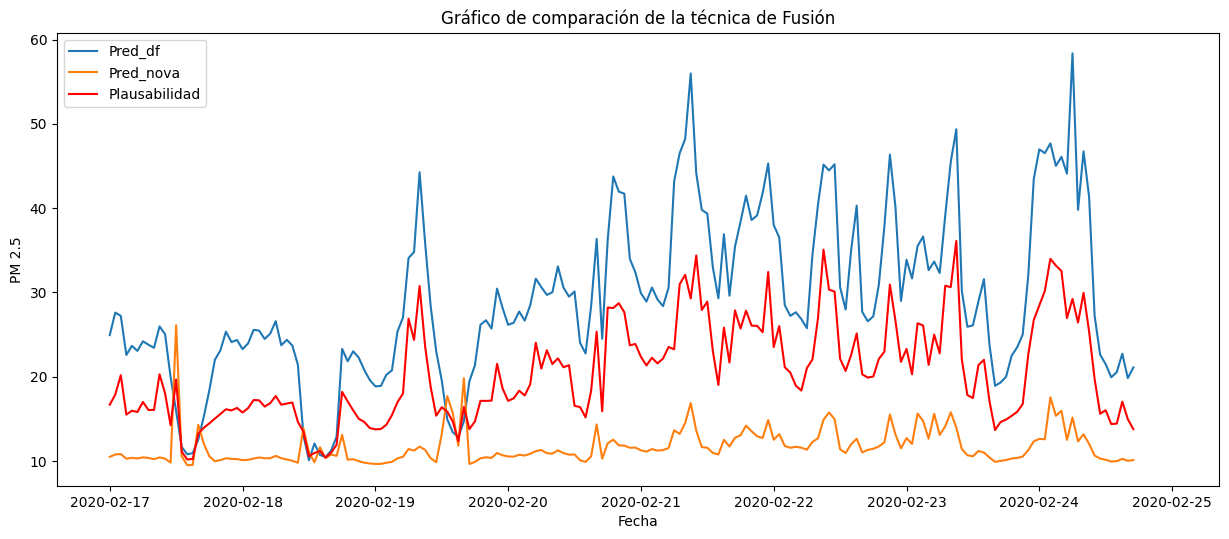

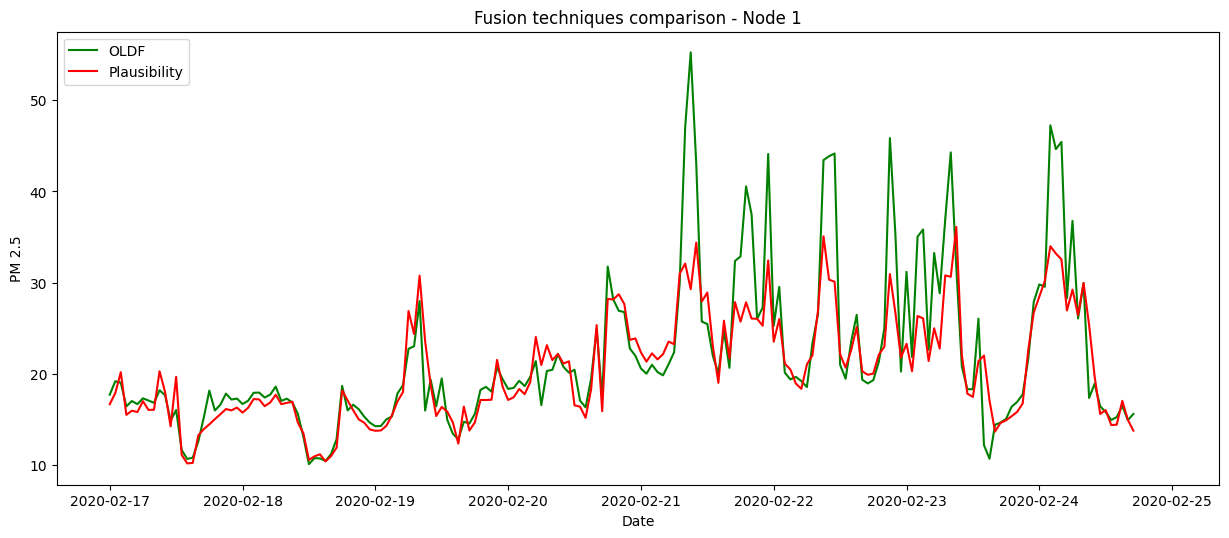

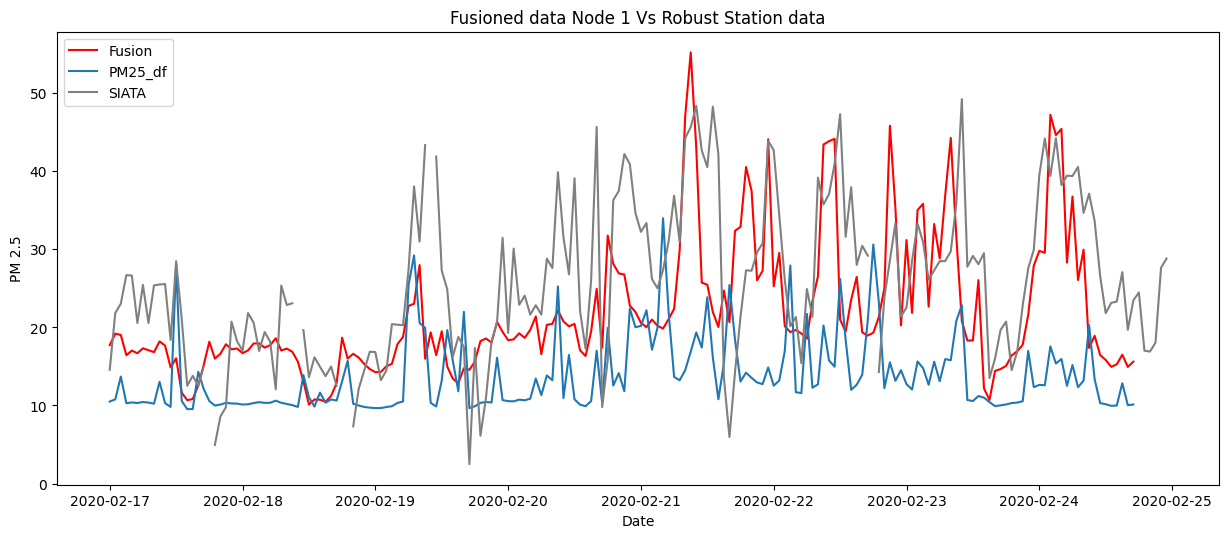

In [381]:

n = 1
rangoFecha = ['2020-02-17','2020-02-24']
prueba = comparacion[comparacion['codigoSerial'] == n]
prueba = prueba[rangoFecha[0]:rangoFecha[1]]
#GRAFICO
plt.figure(figsize=(15, 6), dpi=100)
plt.plot(prueba.index, prueba["Pred_df"],label="Pred_df")
plt.plot(prueba.index, prueba["Pred_nova"],label="Pred_nova")
#plt.plot(prueba.index, prueba["Fusion_OLDF"],olor="green",label="OLDF")
#prueba = fusion[fusion['codigoSerial'] == 169]
plt.plot(prueba.index, prueba["Fusion_P"],color="red",label="Plausabilidad")

#Etiquetas
plt.title("Gráfico de comparación de la técnica de Fusión")
          #+" con media "+str(media)+" y desviación "+str(desviacion))
plt.xlabel("Fecha")
plt.ylabel("PM 2.5")
plt.legend(loc='upper left')
plt.show()


# GRAFICO COMPARACÓN TÉCNICAS
plt.figure(figsize=(15, 6), dpi=100)
#prueba = prueba1[prueba1['codigoSerial'] == 169]
plt.plot(prueba.index, prueba["Fusion_OLDF"],color="green",label="OLDF")
#prueba = fusion[fusion['codigoSerial'] == 169]
plt.plot(prueba.index, prueba["Fusion_P"],color="red",label="Plausibility")

# Etiquetas
plt.title("Fusion techniques comparison - Node 1")
          #+" con media "+str(media)+" y desviación "+str(desviacion))
plt.xlabel("Date")
plt.ylabel("PM 2.5")
plt.legend(loc='upper left')
plt.show()


# GRÁFICO COMPARACIÓN FUSIÓN VS SIATA
plt.figure(figsize=(15, 6), dpi=100)
plt.plot(prueba[prueba['codigoSerial'] == n].index, 
         prueba[prueba['codigoSerial'] == n]['Fusion_OLDF'],
         color="red",
         label="Fusion")
# plt.plot(prueba[prueba['codigoSerial'] == n].index, 
#          prueba[prueba['codigoSerial'] == n]['pm25_df'],
#          label="PM25_df")
plt.plot(prueba[prueba['codigoSerial'] == n].index, 
         prueba[prueba['codigoSerial'] == n]['pm25_nova'],
         label="PM25_df")

plt.plot(datos_SIATA[rangoFecha[0]:rangoFecha[1]].index, datos_SIATA[rangoFecha[0]:rangoFecha[1]]['pm25'],color="grey",label="SIATA")

# Etiquetas
plt.title("Fusioned data Node "+str(n)+" Vs Robust Station data")
          #+" con media "+str(media)+" y desviación "+str(desviacion))
plt.xlabel("Date")
plt.ylabel("PM 2.5")
plt.legend(loc='upper left')
plt.show()
#comparacion[comparacion['codigoSerial'] == 1]['Fusion'].plot()

In [389]:
display(dq_measure_CS_first)
display(dq_measure_CS_correction)
display(dq_measure_CS_fusion)

,comp_df,comp_nova,uncer,prec_df,prec_nova,accu_df,accu_nova,concord,DQ_Index_df,DQ_Index_nova,Codigo_EPA,cant,outl_df,outl_df_%,outl_nova,outl_nova_%
1,0.920,0.920,0.564,0.591,0.000,0.645,0.522,0.077,0.565,0.468,CU,"38,418.000",37.000,0.001,649.000,0.017
119,0.401,0.401,0.853,0.549,0.444,0.634,0.651,0.675,0.636,0.635,U,NaN,NaN,NaN,NaN,NaN
140,0.795,0.795,0.768,0.620,0.342,0.767,0.682,0.351,0.683,0.627,CU,"33,188.000",2.000,0.000,205.000,0.006
149,0.894,0.894,0.853,0.601,0.475,0.606,0.582,0.621,0.698,0.678,CU,"37,334.000",18.000,0.000,284.000,0.008
171,0.505,0.505,0.658,0.628,0.018,0.703,0.598,0.064,0.540,0.448,U,NaN,NaN,NaN,NaN,NaN
211,0.925,0.925,0.950,0.471,0.427,0.623,0.618,0.970,0.780,0.774,CU,"38,644.000",37.000,0.001,59.000,0.002
231,0.757,0.757,0.902,0.598,0.547,0.687,0.545,0.964,0.780,0.719,CU,"31,592.000",5.000,0.000,66.000,0.002
238,0.009,0.009,0.935,0.761,0.823,0.786,0.759,0.831,0.696,0.690,U,NaN,NaN,NaN,NaN,NaN


,comp_df,comp_nova,uncer,prec_df,prec_nova,accu_df,accu_nova,concord,DQ_Index_df,DQ_Index_nova,Codigo_EPA
1,0.920,0.920,0.622,0.605,0.505,0.645,0.470,0.161,0.592,0.515,CU
140,0.795,0.795,0.850,0.620,0.678,0.767,0.691,0.944,0.806,0.781,CU
149,0.894,0.894,0.925,0.607,0.602,0.607,0.608,0.867,0.757,0.756,CU
211,0.925,0.925,0.950,0.473,0.432,0.623,0.618,0.969,0.780,0.775,CU
231,0.757,0.757,0.904,0.599,0.552,0.687,0.545,0.964,0.780,0.720,CU


,comp_P,comp_OLDF,uncer,prec_P,prec_OLDF,accu_P,accu_OLDF,concord,DQ_Index_P,DQ_Index_OLDF,Codigo_EPA
1,0.920,0.920,0.622,0.693,0.600,0.681,0.671,0.161,0.614,0.602,CU
140,0.795,0.795,0.850,0.664,0.661,0.774,0.766,0.944,0.813,0.809,CU
149,0.894,0.894,0.925,0.643,0.639,0.617,0.613,0.867,0.764,0.762,CU
211,0.925,0.925,0.950,0.490,0.490,0.625,0.623,0.969,0.782,0.782,CU
231,0.757,0.757,0.904,0.604,0.596,0.628,0.622,0.964,0.757,0.754,CU


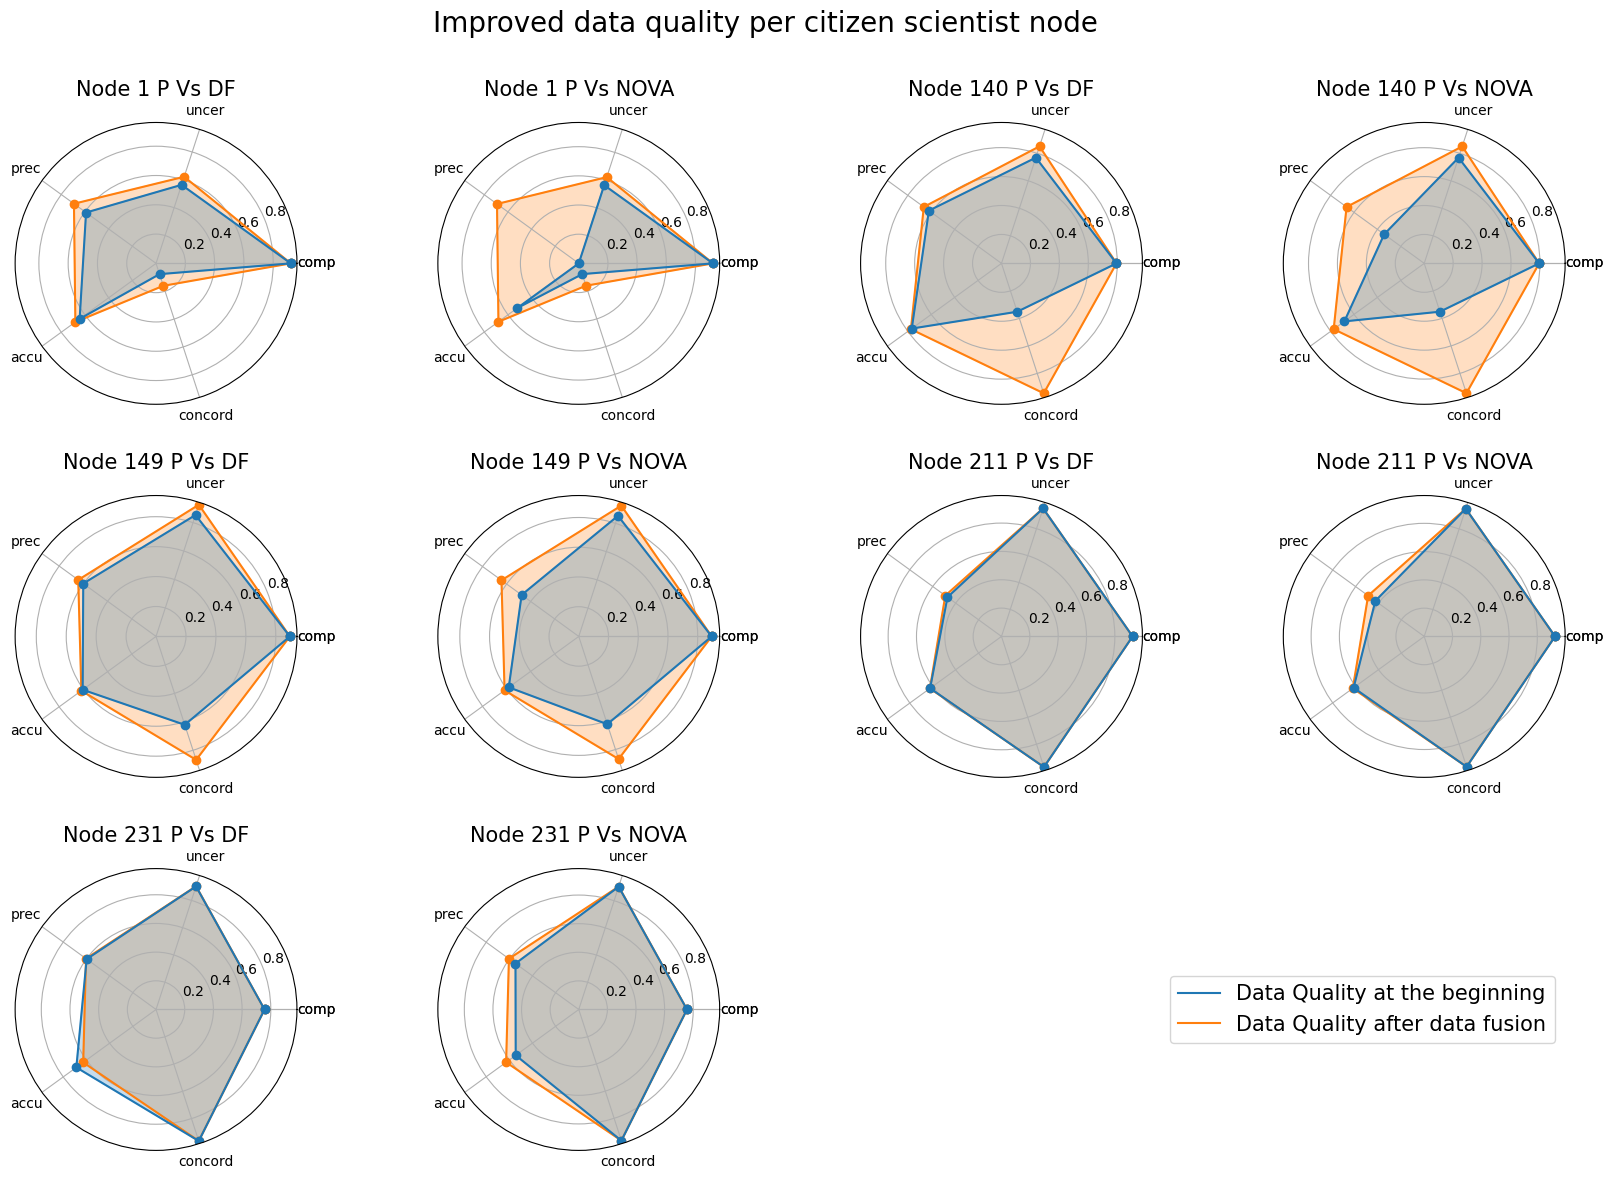

In [17]:
j=0
PLOTS_PER_ROW = 4
nrows = math.ceil((len(dq_measure_CS_fusion)*2)/PLOTS_PER_ROW)
plt.figure(figsize=(20, 14), dpi=100)
plt.subplots_adjust(hspace=0.2, wspace=0.5)
plt.suptitle("Improved data quality per citizen scientist node", fontsize=20, y=0.95)

sensor1 = 'P'

ext = []
for c in dq_measure_CS_first.columns[:8]:
    c1 = c.split('_')
    if (len(c1) > 1) and (c1[1] not in ext):
        ext.append(c1[1])


for nodo in dq_measure_CS_fusion.index:
    for sensor2 in ext:
        DQ_dim1 = {}
        DQ_dim2 = {}
        for c in dq_measure_CS_first.columns[:8]:
            c1 = c.split('_')
            
            if len(set(ext) & set(c1)) > 0:
                if sensor2 in c1:
                    DQ_dim2[c1[0]] = dq_measure_CS_first.loc[nodo][c]
                    DQ_dim1[c1[0]] = dq_measure_CS_fusion.loc[nodo][c1[0]+'_P']
            else:
                DQ_dim2[c1[0]] = dq_measure_CS_first.loc[nodo][c]
                DQ_dim1[c1[0]] = dq_measure_CS_fusion.loc[nodo][c]
    
        dims1 = list(DQ_dim1.keys())
        dims1 = [*dims1, dims1[0]]
        dims2 = list(DQ_dim2.keys())
        dims2 = [*dims2, dims2[0]]

        scores1 = list(DQ_dim1.values())
        scores1 = [*scores1, scores1[0]]
        scores2 = list(DQ_dim2.values())
        scores2 = [*scores2, scores2[0]]

        label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(dims1))

        axs = plt.subplot(nrows, PLOTS_PER_ROW, j+1, polar=True)
        
        axs.plot(label_loc, scores1, 'o-', c='#ff7f0e')
        axs.plot(label_loc, scores2, 'o-', c='#1f77b4')
        

        axs.set_title('Node '+str(nodo)+' '+str(sensor1)+' Vs '+str(sensor2).upper(), size=15)
        plt.thetagrids(np.degrees(label_loc), labels=dims1)
        axs.fill(label_loc, scores1, alpha=0.25, c='#ff7f0e')
        axs.fill(label_loc, scores2, alpha=0.25, c='#1f77b4')     
        
        j+=1
    
axs = plt.subplot(nrows, PLOTS_PER_ROW, j+2, polar=False)
axs.plot(1)
axs.plot(2)
plt.axis('off')
plt.legend(['Data Quality at the beginning', 'Data Quality after data fusion'], loc='center right', fontsize=15)
#plt.savefig("begin-vs-fusion.svg", dpi=200, bbox_inches='tight')
plt.show()        
        

In [ ]:
def get_var_name(variable):
     # Obtiene el nombre de una variable como string
     for name, value in globals().items():
        if value is variable:
            return name

todos = pd.DataFrame()
dq_measure_CS_df = pd.DataFrame()
dq_measure_CS_nova = pd.DataFrame()
dq_measure_CS_P = pd.DataFrame()
dq_measure_CS_OLDF = pd.DataFrame()
for t in [dq_measure_CS_first, dq_measure_CS_correction, dq_measure_CS_fusion]:
    name = get_var_name(t).split('_')[-1]
    secc = t.iloc[:, 0:10]
    secc['results'] = name
    
    if secc.columns.str.contains('_df').any():
        cols = list(secc.columns[secc.columns.str.contains('nova')])
        cols[-1:-1] = ['uncer', 'concord', 'results']
        dq_measure_CS_nova = pd.concat([dq_measure_CS_nova, secc.loc[:, cols]], ignore_index=False)
        dq_measure_CS_nova['sensor'] = 'nova'
        
        cols = list(secc.columns[secc.columns.str.contains('df')])
        cols[-1:-1] = ['uncer', 'concord', 'results']
        dq_measure_CS_df = pd.concat([dq_measure_CS_df, secc.loc[:, cols]], ignore_index=False)
        dq_measure_CS_df['sensor'] = 'df'
    
    else:
        for s in ['df', 'nova']:
            cols = list(secc.columns[secc.columns.str.contains('_P')])
            cols[-1:-1] = ['uncer', 'concord', 'results', 'sensor']      
            secc['sensor'] = s
            secc['results'] = 'fusion_P'
            dq_measure_CS_P = pd.concat([dq_measure_CS_P, secc.loc[:, cols]], ignore_index=False)
            
            cols = list(secc.columns[secc.columns.str.contains('OLDF')])
            cols[-1:-1] = ['uncer', 'concord', 'results', 'sensor']
            secc['sensor'] = s
            secc['results'] = 'fusion_OLDF'
            dq_measure_CS_OLDF = pd.concat([dq_measure_CS_OLDF, secc.loc[:, cols]], ignore_index=False)
            
dq_measure_CS_df = dq_measure_CS_df.rename(columns={'comp_df':'comp',	'prec_df':'prec',	'accu_df':'accu',	'DQ_Index_df':'DQ_Index'})
dq_measure_CS_nova = dq_measure_CS_nova.rename(columns={'comp_nova':'comp',	'prec_nova':'prec',	'accu_nova':'accu',	'DQ_Index_nova':'DQ_Index'})
dq_measure_CS_P = dq_measure_CS_P.rename(columns={'comp_P':'comp',	'prec_P':'prec',	'accu_P':'accu',	'DQ_Index_P':'DQ_Index'})
dq_measure_CS_OLDF = dq_measure_CS_OLDF.rename(columns={'comp_OLDF':'comp',	'prec_OLDF':'prec',	'accu_OLDF':'accu',	'DQ_Index_OLDF':'DQ_Index'})

todos = pd.concat([todos, dq_measure_CS_df, dq_measure_CS_nova, dq_measure_CS_P, dq_measure_CS_OLDF], ignore_index=False)
#todos = todos.set_index(['sensor', 'comp']).sort_index()
todos


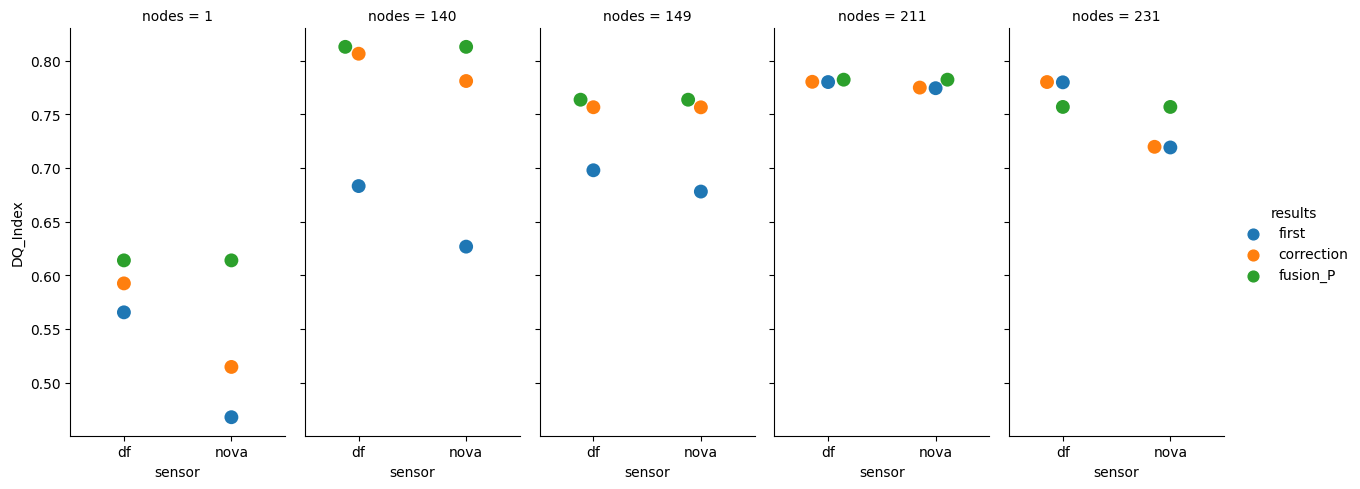

In [388]:
# import seaborn as sns

ax = sns.catplot(x="sensor", 
            y="DQ_Index", 
            col="nodes", 
            hue="results", 
            kind="swarm", 
            data=todos[(todos['nodes'].isin(nodos) & (todos['results'] != 'fusion_OLDF'))],
            aspect=.5,
            s=10)

#plt.title('Categorical Plot')

#todos[(todos['nodes'].isin(nodos))]


In [387]:
todos[(todos['nodes'].isin(nodos) & (todos['results'] != 'fusion_OLDF'))]


,nodes,comp,prec,accu,uncer,concord,results,DQ_Index,sensor
0,1,0.920,0.591,0.645,0.564,0.077,first,0.565,df
2,140,0.795,0.620,0.767,0.768,0.351,first,0.683,df
3,149,0.894,0.601,0.606,0.853,0.621,first,0.698,df
5,211,0.925,0.471,0.623,0.950,0.970,first,0.780,df
6,231,0.757,0.598,0.687,0.902,0.964,first,0.780,df
8,1,0.920,0.605,0.645,0.622,0.161,correction,0.592,df
9,140,0.795,0.620,0.767,0.850,0.944,correction,0.806,df
10,149,0.894,0.607,0.607,0.925,0.867,correction,0.757,df
11,211,0.925,0.473,0.623,0.950,0.969,correction,0.780,df
12,231,0.757,0.599,0.687,0.904,0.964,correction,0.780,df


In [79]:
#todos[todos['nodos'] == 1][['prec', 'results']].plot(kind='bar', x='results')
#todos[todos['nodos'] == 1][['comp',	'prec',	'accu',	'uncer', 'concord', 'results']].set_index('results').T
todos

,nodos,comp,prec,accu,uncer,concord,results,DQ_Index,sensor
0,1,0.920,0.591,0.645,0.564,0.077,first,0.565,df
1,119,0.401,0.549,0.634,0.853,0.675,first,0.636,df
2,140,0.795,0.620,0.767,0.768,0.351,first,0.683,df
3,149,0.894,0.601,0.606,0.853,0.621,first,0.698,df
4,171,0.505,0.628,0.703,0.658,0.064,first,0.540,df
5,211,0.925,0.471,0.623,0.950,0.970,first,0.780,df
6,231,0.757,0.598,0.687,0.902,0.964,first,0.780,df
7,238,0.009,0.761,0.786,0.935,0.831,first,0.696,df
8,1,0.920,0.605,0.645,0.622,0.161,correction,0.592,df
9,140,0.795,0.620,0.767,0.850,0.944,correction,0.806,df


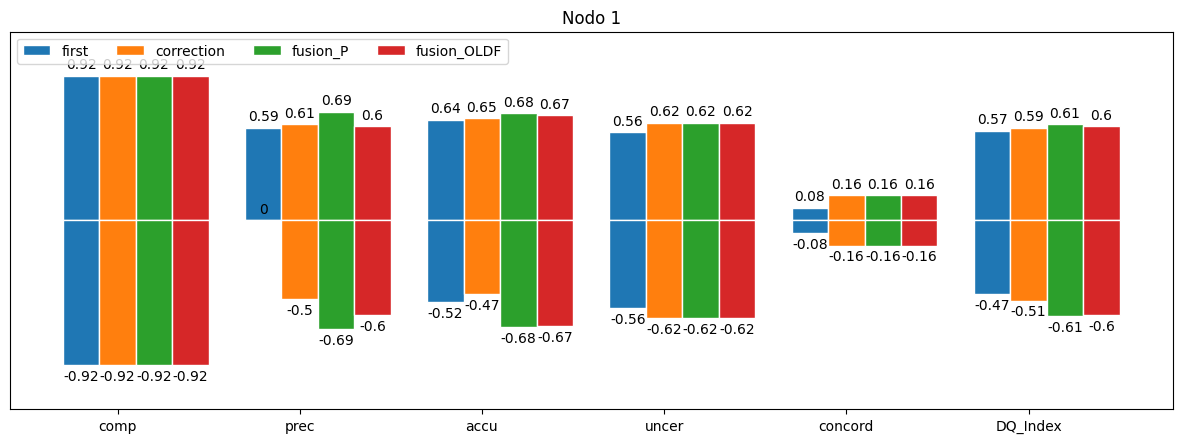

In [300]:
if 'nodes' not in todos.columns:
    todos.reset_index(inplace=True)
    todos.rename(columns={'index':'nodes'}, inplace=True)

n = 1

filtro_df = todos.set_index(['nodes','sensor']).loc[n,'df'][['comp','prec',	'accu',	'uncer', 'concord', 'results', 'DQ_Index']].set_index('results').T
filtro_nova = todos.set_index(['nodes','sensor']).loc[n,'nova'][['comp','prec',	'accu',	'uncer', 'concord', 'results', 'DQ_Index']].set_index('results').T


penguin_means_df = {}
penguin_means_nova = {}
for c in filtro_df.columns:
    penguin_means_df[c] = np.round(np.array(filtro_df[c].values), 2)

for c in filtro_nova.columns:
    penguin_means_nova[c] = np.round(np.array(filtro_nova[c].values), 2)

species = list(filtro_df.index)

x = np.arange(len(species))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(15,5))


for measurement_df, measurement_nova, colors in zip(penguin_means_df.items(), penguin_means_nova.items(), ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']):
    #measurement = [ round(elem, 2) for elem in measurement ]
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement_df[1], width, label=measurement_df[0], color = colors, edgecolor='white')
    ax.bar_label(rects, padding=3)
    rects = ax.bar(x + offset, measurement_nova[1] * -1, width, color = colors, edgecolor='white')
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
#ax.set_ylabel('Length (mm)')
ax.set_title('Nodo '+str(n))
ax.set_xticks(x + width, species)
ax.set_yticks([])
ax.legend(ncols=len(species), loc='upper left')
ax.set_ylim(-1.2, 1.2)

plt.show()

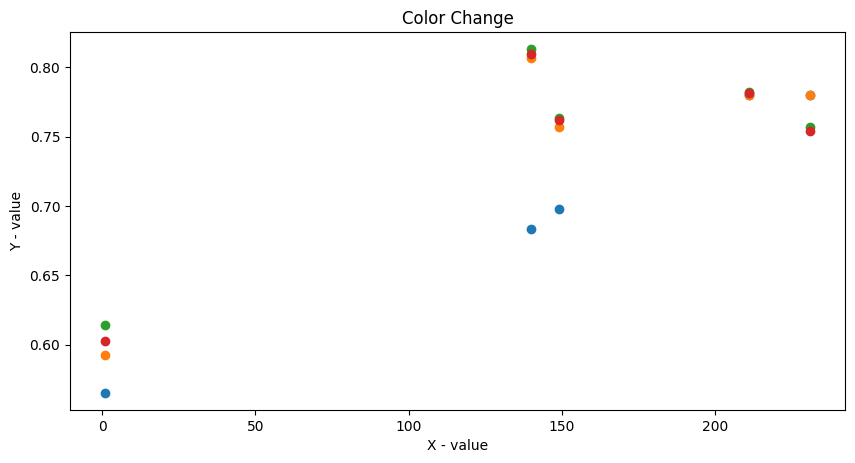

In [301]:
filtro = todos.set_index(['nodes','results'], drop=True).groupby('nodes')[['sensor','DQ_Index']].apply(lambda x:x)

DQ_Index = pd.DataFrame(index=nodos, columns=filtro.index.get_level_values(2).unique())
for n in nodos:
    DQ_Index.loc[n] = filtro[filtro['sensor'] == 'df'].loc[n]['DQ_Index'].values
DQ_Index




plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':100})
for n in DQ_Index.columns:
    #y = DQ_Index.loc[n].values
    plt.scatter(nodos, DQ_Index[n].values)

# Decorate
plt.title('Color Change')
plt.xlabel('X - value')
plt.ylabel('Y - value')
plt.show()

In [ ]:
importlib.reload(f_DQM)
importlib.reload(f_FS)

comparacion = dataf.groupby(['codigoSerial'])['pm25_df','pm25_nova','Pred_df','Pred_nova'].resample('H').mean()
comparacion.reset_index(level=['codigoSerial'], inplace=True)
comparacion['Fusion-P'] = fusion['Fusion']
comparacion['Fusion-OLDF'] = prueba1['Fusion']

print('\nAccuracy')
display(f_DQM.accuracy2(datos_SIATA[['pm25']], comparacion))

print('\nRMSE')
display(f_FS.rmse(datos_SIATA[['pm25']], comparacion))

# print('\nCross-Correlation')
# display(f_FS.cross_correlation(datos_SIATA[['pm25']], comparacion, nonan=True))

# print('\nEuclidean Distance')
# display(f_FS.dist_euclidean(datos_SIATA[['pm25']], comparacion, nonan=True))

# print('\nDynamic Time Warping')  #https://cs.fit.edu/~pkc/papers/tdm04.pdf
# display(f_FS.dtw(datos_SIATA[['pm25']], comparacion, nonan=True))


In [ ]:
importlib.reload(f_FS)

#cercania = 0.8 # en kms
coor_siata = datos_SIATA.groupby('codigoSerial')['longitud', 'latitud'].mean()
coor_CS = df_CS.groupby('codigoSerial')['longitud', 'latitud'].mean()

cercanos = f_FS.nodos_cercanos(coor_CS, coor_siata, cercania)

print(cercanos)
# print('Nodos SIATA sin CS cercanos',nodos)

In [ ]:
nodo = 34
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(comparacion[comparacion['codigoSerial'] == nodo].index, 
         comparacion[comparacion['codigoSerial'] == nodo]['Fusion-P'],
         color="green",
         label="Fusion")
plt.plot(datos_SIATA.index, datos_SIATA['pm25'],color="red",label="SIATA")
plt.legend(loc='upper left')
plt.show()
#comparacion[comparacion['codigoSerial'] == 1]['Fusion'].plot()

In [ ]:
import geopandas as gpd


#coor_siata = df_SIATA.groupby(['codigoSerial'])[['latitud', 'longitud']].mean()  # Todos los nodos SIATA
#coor_siata = coor_siata.filter(items=nodos, axis=0)
coor_siata = datos_SIATA.groupby(['codigoSerial'])['latitud', 'longitud'].mean() # Solo el nodo SIATA selecionado

coordenados = df_CS[['codigoSerial', 'fecha', 'hora', 'pm25_df', 'pm25_nova', 'latitud', 'longitud', 'alturaNivelMar', 'alturaNivelPiso']]
coor = coordenados.groupby(['codigoSerial'])[['latitud', 'longitud']].mean()

result = coor.join(f_DQM.accuracy2(datos_SIATA[['pm25']], fusion), how="inner")

#ruta = "E:/"
mapa = gpd.read_file(ruta+'Colombia/Antioquia/Politico/').to_crs(epsg=4326)

mapa['centroid'] = mapa.centroid

#gdf = gpd.GeoDataFrame(coor, geometry=gpd.points_from_xy(coor.longitud, coor.latitud)) # Todos los nodos de CS
gdf = gpd.GeoDataFrame(result, geometry=gpd.points_from_xy(result.longitud, result.latitud)) # Solo los nodos cd CS cercanos al nodo SIATA seleccionado
gdf_siata = gpd.GeoDataFrame(coor_siata, geometry=gpd.points_from_xy(coor_siata.longitud, coor_siata.latitud))

fig, ax = plt.subplots()
# Añade recuadro 1
axins = ax.inset_axes([0.5, 0.25, 0.45, 0.45])

# Gráfica recuadro 1
mapa.query('SUBREGION=="AMVA"').plot(ax=axins, color='white', edgecolor='black')

# limita área a mostrar recuadro 1
axins.set(ylabel='', xlabel='', xlim=(-75.57, -75.53), ylim=(6.24, 6.275), xticks=[], yticks=[])
axins.set_title('Citizen Scientist nodes', y=-0.01)

mapa.query('SUBREGION=="AMVA"').plot(ax=ax, color='white', edgecolor='black')
mapa.query('SUBREGION=="AMVA"').apply(lambda x: ax.annotate(text=x['MPIO_CNMBR'], 
                                                            xy=(x['centroid'].coords[0][0],x['centroid'].coords[0][1]), 
                                                            ha='center'), axis=1)
fig.set_size_inches(10, 10)
gdf.apply(lambda x: axins.annotate(text=x.name, xy=(x['longitud'],x['latitud']), ha='center'), axis=1)
gdf_siata.plot(ax=axins, color='blue')
gdf.plot(ax=axins, color='red')
gdf_siata.apply(lambda x: axins.annotate(text=x.name, xy=(x['longitud']+0.003,x['latitud']), ha='center'), axis=1)
#gdf.apply(lambda x: axins.annotate(text=x.name, xy=(x['longitud'],x['latitud']), ha='center'), axis=1)

#gdf = gpd.GeoDataFrame(coor, geometry=gpd.points_from_xy(coor.longitud, coor.latitud))
gdf.plot(ax=ax, color='red')
gdf_siata.plot(ax=ax, color='blue')
ax.indicate_inset_zoom(axins)
plt.savefig("map-CS-nodes.eps", dpi=200, bbox_inches='tight')
plt.show()


In [ ]:
# Mapas superficie con marca de calor https://geopandas.org/en/stable/gallery/plotting_with_folium.html

#mapa = gpd.read_file(ruta+'Colombia/Antioquia/Politico/').to_crs(epsg=4326)

mapa.query('SUBREGION=="AMVA"')

In [ ]:
results = pd.read_csv(ruta+"Fusion-results_v2.csv",sep=",")
results

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
anova = pd.read_csv(ruta+"Fusion-results_v2.csv",sep=",")
ax.set_title('RMSE vs Técnica')
sns.boxplot(x="Tecnica", y="RMSE", data=anova, ax=ax)
sns.swarmplot(x="Tecnica", y="RMSE", data=anova, color='black', alpha=0.5, ax=ax)

print('RMSE medio y desviación típica por Técnica')
anova.groupby('Tecnica')['RMSE'].agg(['mean', 'std'])

In [ ]:
# ANOVA
import pingouin as pg
pg.rm_anova(
    data       = anova,
    dv         = 'RMSE',
    within     = 'Tecnica',
    subject    = 'Estacion_CS',
    detailed   = True,
    correction = 'auto'
).round(4)

In [ ]:
# Post-hoc pairwise t-test
# ==============================================================================
pg.pairwise_ttests(
    dv      = 'RMSE',
    within  = 'Tecnica',
    subject = 'Estacion_CS',
    padjust = 'holm',
    data    = anova
)

In [ ]:
#ANOVA
import statsmodels.api as sm
import scipy.stats as sci
from statsmodels.formula.api import ols

anova = pd.read_csv(ruta+"Fusion-results_v2.csv",sep=",")
anova.rename(columns={'Distancia(m)':'Distancia'}, inplace=True)
#print(anova.head(10))

mod = ols('RMSE ~ Tecnica', data=anova).fit()

aov_table = sm.stats.anova_lm(mod, typ=2)
print("\n****** RMSE ANOVA ******")
print(aov_table,'\n')

print(sci.shapiro(anova['RMSE']),'\n')

anova = pd.read_csv(ruta+"Fusion-results.csv",sep=",")
anova['diff'] = anova['RMSE_P'] / anova['RMSE_OLDF']
anova.rename(columns={'Distancia(m)':'Distancia'}, inplace=True)
#print(anova.head(10))

mod = ols('diff ~ Distancia', data=anova).fit()

aov_table = sm.stats.anova_lm(mod, typ=2)
print("\n****** diff ANOVA ******")
print(aov_table,'\n')

sci.shapiro(anova['diff'])

In [ ]:
from matplotlib import pyplot as plt
importlib.reload(f_OC)
fusion_Res = pd.read_csv(ruta+"Fusion-results.csv",sep=",")

fusion_Res['diff'] = fusion_Res['RMSE_P'] / fusion_Res['RMSE_OLDF']
fusion_Res['diff'].plot(kind='density', figsize=(15,7), label='diff')
#fusion_Res['RMSE-P'].plot(kind='density', figsize=(15,7), label='diff')

mejor = f_OC.check_function_scipy(fusion_Res['diff'])
funct = mejor.iloc[6]
params = mejor.iloc[2:4]
params = [p for p in params if ~np.isnan(p)]

# x = np.linspace(funct.ppf(0.01, *params), funct.ppf(0.99, *params), 100)
# fig, ax = plt.subplots(1, 1)
# #ax.hist(fusion_Res['diff'], density=True, histtype='stepfilled', alpha=0.2)
# rv = funct(*params)
# ax.plot(x, rv.pdf(x), 'r-', lw=2)


# mejor = df.loc[1, ]
# funct = mejor.iloc[7]
# params = mejor.iloc[2:7]
# params = [p for p in params if ~np.isnan(p)]
# # stats = funct.stats(*params, 'mvsk')
# # funct.mean(min(data), max(data))

# a, b = 10, 90
# x = np.linspace(funct.ppf(0.0001, a, b), funct.ppf(0.9999, a, b), 100)
# fig, ax = plt.subplots(1, 1)
# #ax.hist(fusion_Res['diff'], density=True, histtype='stepfilled', alpha=0.2)
# rv = funct(a, b)
# ax.plot(x, rv.pdf(x), 'r-', lw=2)

mejor

In [ ]:
from scipy import stats
mean, var = funct.stats(*params, moments='mv')
print(mean, var)

stats.kstest(fusion_Res['diff'], mejor[0], params, len(fusion_Res['diff']))

stats.kruskal(fusion_Res['RMSE_P'], fusion_Res['RMSE_OLDF'])


In [ ]:
importlib.reload(f_DF)
prueba = f_DF.OLDF(datos_c)

#datos[datos['codigoSerial']==149][650:660]
prueba[prueba['codigoSerial'] == 1][['Pred_df', 'Pred_nova', 'Fusion']].plot(figsize=(13, 5))

In [ ]:
import funciones_OC as f_OC

importlib.reload(f_OC)

# Calculo de estadísticos de los datos por hora, dia y nodo.
entreno, estadisticos_df = f_OC.estacionalidad(entreno, 'pm25_df')

# Calculo de los estadísticos consolidados por hora de todos los nodos en todos los días.
#consolidado_df = f_OC.est_consol(estadisticos_df, 'media')

# Corrección del outlier por el método de ponderación.
#datos_corregidos = f_OC.corregir_ponderado(datos, outliers_detected)

In [ ]:
outliers_detected[1]['pm25_df'][:10]

In [ ]:
from sklearn.neighbors import KernelDensity
df = fusion.loc[fusion.loc[:,'codigoSerial'] == 1]
df['pm25_df'].iloc[outliers_detected[1]['pm25_df']] = np.nan
fecha = df[552:553].index
filtro = df[df.index.hour == fecha.hour[0]]['pm25_df']
filtro.plot(kind='density', figsize=(15,7), label='pm25_df')

df = datos_d.loc[datos_d.loc[:,'codigoSerial'] == 1]
#df['Pred_df'].iloc[outliers_detected[1]['pm25_df']] = np.nan
fecha = df[552:553].index
filtro = df[df.index.hour == fecha.hour[0]]['Pred_df']
filtro.plot(kind='density', figsize=(15,7), label='Pred_df')
plt.legend()
plt.show()

print(fecha)




In [ ]:
nube = 1
for variable in outliers_detected[nube].keys():
    datos_nube = datos_d.loc[datos_d.loc[:,'codigoSerial'] == nube]
    sensor = variable.split('_')
    datos_nube[[variable, 'Pred_'+sensor[1]]].plot(figsize=(10,5))
    plt.show()
    


In [ ]:
# Distribuciones en la librería scipy.stats
importlib.reload(f_OC)
import datetime
datos_nube = fusion.loc[fusion.loc[:,'codigoSerial'] == 1]

variable = 'pm25_df'

datos_nube[variable].iloc[outliers_detected[1][variable]] = np.nan
dist = pd.DataFrame()

for i in range(24):
    filtro = datos_nube[datos_nube.index.hour == i][variable]
    
    # Distribuciones en la librería scipy.stats
    mejor = f_OC.check_function_scipy(filtro)
    dist = dist.append(mejor, ignore_index=True)

dist


In [ ]:
# Distribuciones en la librería sklearn
importlib.reload(f_OC)
import datetime
datos_nube = fusion.loc[fusion.loc[:,'codigoSerial'] == 1]
variable = 'pm25_df'
datos_nube[variable].iloc[outliers_detected[1][variable]] = np.nan
dist1 = pd.DataFrame()
for i in range(24):
    filtro = datos_nube[datos_nube.index.hour == i][variable]
    mejor = f_OC.check_function_sklearn(filtro)
    dist1 = dist1.append(mejor, ignore_index=True)

dist1

In [ ]:
# Comparación de distribucione por validación cruzada https://medium.com/the-researchers-guide/finding-the-best-distribution-that-fits-your-data-using-pythons-fitter-library-319a5a0972e9

# Gráfico comparativo entre la distribución de los datos y la función de distribución que más se ajusta
from sklearn.neighbors import KernelDensity

hora = 15

filtro = datos_nube[datos_nube.index.hour == hora][variable]

mejor = dist.iloc[hora]
funct = mejor.iloc[-1]
params = mejor.iloc[2:-1]
params = [p for p in params if ~np.isnan(p)]
data = filtro[filtro.notnull()].values

#ks = int(1 + 3.322 * np.log10(len(data))) # Calculo de número de bins por regla de Sturges
ks = 20

x = np.linspace(funct.ppf(0.0001, *params), funct.ppf(0.9999, *params), 100)

print('********************************* Mejor Función de probablilidad *********************************')

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(2, 1, 1)
ax.hist(filtro, density=True, alpha=0.5, bins=ks, edgecolor="k", zorder=5)
print(mejor[0], 'params:', params)
rv = funct(*params)
ax.plot(x, 
        rv.pdf(x), 
        '-', 
        lw=2, 
        zorder=10,
        label=mejor[0])

plt.grid(True, zorder=-5)
ax.set_xlim([min(data), max(data)])
ax.legend()

mejor = dist1.iloc[hora]
funct = mejor.iloc[-1]
print(funct)

ax = fig.add_subplot(2, 1, 2)
ax.hist(filtro, density=True, alpha=0.5, bins=ks, edgecolor="k", zorder=5)
#ax.scatter(data, np.zeros_like(data), marker="x", color="red")
kd_lunch = funct.fit(np.sort(data)[:, np.newaxis])
kd_vals = np.exp(kd_lunch.score_samples(np.sort(data)[:, np.newaxis]))
ax.plot(
    np.sort(data),
    kd_vals,
    linestyle="-",
    lw=2,
    zorder=10,
    label=funct.kernel
)

plt.grid(True, zorder=-5)
ax.set_xlim([min(data), max(data)])
ax.legend()
plt.show()



In [ ]:
get_common_distributions()

In [ ]:
# Basado en: https://medium.com/the-researchers-guide/finding-the-best-distribution-that-fits-your-data-using-pythons-fitter-library-319a5a0972e9
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

data = filtro[filtro.notnull()].values

f = Fitter(data, 
           distributions= get_common_distributions())
f.fit(progress=False)
f.summary(Nbest=5, lw=2, plot=True, method='sumsquare_error', clf=True)



In [ ]:
f.get_best(method = 'sumsquare_error')

In [ ]:
from fitter import HistFit
from pylab import hist
import scipy.stats
data = filtro[filtro.notnull()].values
Y, X, _ = hist(data, bins=10)
hf = HistFit(X=X, Y=Y)
hf.fit(error_rate=0.03, Nfit=20)
print(hf.mu, hf.sigma, hf.amplitude)

In [ ]:
Y

In [ ]:
importlib.reload(f_TS)
f_TS.flinger_test(fusion, N, debug='N')

In [ ]:
from scipy.stats import (
    norm, beta, expon, gamma, logistic, lognorm, uniform, dweibull, dgamma, powernorm, weibull_max, 
    weibull_min, laplace, alpha, halfnorm, halflogistic, invgauss, invgamma, loglaplace, loggamma, 
    maxwell, pareto, powerlognorm, invweibull, cosine, exponweib, t, rdist
    )
data = filtro[filtro.notnull()].values
para = expon.fit(data)

In [ ]:
max(data)

In [ ]:

hora = 2

filtro = datos_nube[datos_nube.index.hour == hora][variable]

data = filtro[filtro.notnull()].values

mejor = dist1.iloc[hora]
funct = mejor.iloc[-1]
print(funct)

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1)
ax.hist(filtro, density=True, alpha=0.5, bins=50, edgecolor="k", zorder=5)
#ax.scatter(data, np.zeros_like(data), marker="x", color="red")
kd_lunch = KernelDensity(bandwidth=1, kernel='exponential').fit(np.sort(data)[:, np.newaxis])
kd_vals = np.exp(kd_lunch.score_samples(np.sort(data)[:, np.newaxis]))
ax.plot(
    np.sort(data),
    kd_vals,
    linestyle="-",
    lw=2,
    zorder=10,
    label=funct.kernel
)

plt.grid(True, zorder=-5)
ax.set_xlim([min(data), max(data)])
ax.legend()
plt.show()

In [ ]:
#Basado en: https://www.cienciadedatos.net/documentos/pystats02-kernel-density-estimation-kde-python.html
ensayo = filtro.copy()
ensayo = pd.DataFrame(ensayo)
ensayo['minutos'] = ensayo.index.minute
ensayo = ensayo[ensayo[filtro.name].notna()]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.5, 4))
ax.scatter(ensayo.minutos, ensayo[filtro.name], color="#3182bd", alpha=0.5)
ax.set_title('Distribución de valores por minuto')
ax.set_xlabel('minuto')
ax.set_ylabel(filtro.name);

In [ ]:
# Cross-Validation del parámetro bandwidth
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from statsmodels.nonparametric.kde import kernel_switch

data = filtro[filtro.notnull()].values
#bandwidths = 10 ** np.linspace(-1, 10, 20)
bandwidths = np.linspace(0.01, 10, 30)

kde = sm.nonparametric.KDEUnivariate(data)

mlh = float('-inf')
kernels = list(kernel_switch.keys())
ban = True
while ban:
    grid = GridSearchCV(kde.fit(fft=False, gridsize=2 ** 10),
                        {'bw': bandwidths,
                        'kernel': kernels},
                        cv=20) # 20-fold cross-validation
    grid.fit(data)
    
    if (grid.best_score_ > mlh):
        mlh = grid.best_score_
        pos = list(bandwidths).index(grid.best_params_['bandwidth'])
        if pos==0:
            inf, sup = 0, pos+1
        else:
            inf, sup = pos-1, pos+1

        bandwidths = np.linspace(bandwidths[inf], bandwidths[sup], 30)
        bandwidths = np.append(bandwidths, grid.best_params_['bandwidth'])
        bandwidths = np.sort(bandwidths)

    else:
        ban = False
grid.best_params_

In [ ]:
mejores = [(grid.cv_results_['params'][list(grid.cv_results_['rank_test_score']).index(i)], grid.cv_results_['mean_test_score'][list(grid.cv_results_['rank_test_score']).index(i)]) for i in range(1,4)]

colors = ["navy", "cornflowerblue", "darkorange"]#, "limegreen", "brown", "peru"]

fig, ax = plt.subplots(1, 1)
ax.hist(data, density=True, alpha=0.5, bins=20, edgecolor="k", zorder=5)

for i,col in zip(range(len(mejores)), colors):
    kd_lunch = KernelDensity(kernel=mejores[i][0]['kernel'], bandwidth=mejores[i][0]['bandwidth']).fit(np.sort(data)[:, np.newaxis])
    kd_vals = np.exp(kd_lunch.score_samples(np.sort(data)[:, np.newaxis]))
    ax.plot(
        np.sort(data),
        kd_vals,
        linestyle="-",
        color=col,
        lw=2,
        zorder=10,
        label=mejores[i][1]
    )
    plt.grid(True, zorder=-5)
    ax.set_xlim([min(data), max(data)])

plt.tight_layout()
ax.legend()
plt.show()

In [ ]:
# Gráfico comparativo entre la distribución de los datos y la función de distribución que más se ajusta
from sklearn.neighbors import KernelDensity
funct = mejor.iloc[-1]
params = mejor.iloc[2:-2]
params = [p for p in params if ~np.isnan(p)]
data = filtro[filtro.notnull()].values

x = np.linspace(funct.ppf(0.0001, *params), funct.ppf(0.9999, *params), 100)

print('********************************* Mejor Función de probablilidad *********************************')
fig, ax = plt.subplots(1, 1)
ax.hist(filtro, density=True, alpha=0.5, bins=20, edgecolor="k", zorder=5)
rv = funct(*params)
ax.plot(x, rv.pdf(x), '-', lw=2, zorder=10)
ax.scatter(data, np.zeros_like(data), marker="x", color="red")
plt.grid(True, zorder=-5)
ax.set_title('Kernel function "{}"'.format(mejor[0]))
ax.set_xlim([min(data), max(data)])
plt.show()

#*************************************************************************************************************
#*************************************************************************************************************
#*************************************************************************************************************

# Gráfico de función de densidad vs histograma de los datos
# Basado en: https://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html#sphx-glr-auto-examples-neighbors-plot-kde-1d-py

#bw = grid.best_estimator_.bandwidth
#fig, ax = plt.subplots()
#ax.fill(data, fc="black", alpha=0.2, label="input distribution")
#ax.hist(filtro, density=True, alpha=0.2)
data = filtro[filtro.notnull()].values
colors = ["navy"]#["navy", "cornflowerblue", "darkorange", "limegreen", "brown", "peru"]
kernels = ["gaussian", "epanechnikov", "tophat",  "exponential", "linear", "cosine"]
bandwidths = [3, 4, 0.9, 3, 7, 4]

print('******************** Comparación de los kernel libreria sklearn.neighbors.KernelDensity ********************')
# Create a figure
fig = plt.figure(figsize=(12, 5))

# Enumerate every option for the kernel
for i, kernel, bw in zip(range(len(kernels)), kernels, bandwidths):

    # Create a subplot, set the title
    ax = fig.add_subplot(3, 3, i + 1)
    ax.set_title('Kernel function "{}"'.format(kernel))

    # Plot the histogram
    ax.hist(
        data,
        bins=20,
        density=True,
        label="Histogram from samples",
        zorder=5,
        edgecolor="k",
        alpha=0.5,
    )

    # Fit the model (estimate densities)
    kd_lunch = KernelDensity(kernel=kernel, bandwidth=bw).fit(np.sort(data)[:, np.newaxis])
    kd_vals = np.exp(kd_lunch.score_samples(np.sort(data)[:, np.newaxis]))
    ax.plot(
        np.sort(data),
        kd_vals,
        linestyle="-",
        lw=2,
        zorder=10
    )
    ax.scatter(data, np.zeros_like(data), marker="x", color="red")
    plt.grid(True, zorder=-5)
    ax.set_xlim([min(data), max(data)])

plt.tight_layout()
plt.show()

#*************************************************************************************************************
#*************************************************************************************************************
#*************************************************************************************************************
# Comparación de funciones de probabilidad por función de densidad usando la librería de statsmodels
# Fuente: https://www.statsmodels.org/devel/examples/notebooks/generated/kernel_density.html

import statsmodels.api as sm
from statsmodels.nonparametric.kde import kernel_switch

print('******************** Comparación de los kernel libreria sm.nonparametric.KDEUnivariate ********************')
kde = sm.nonparametric.KDEUnivariate(data)
bandwidths = [2.55, 4, 5, 3, 7, 4, 4, 4]
#bandwidths = dict(zip(kernel_switch.keys(), [3, 4, 0.9, 3, 7, 1, 4, 4]))
# Create a figure
fig = plt.figure(figsize=(12, 5))

entropy = {}
# Enumerate every option for the kernel
for i, kernel, bw in zip(range(len(kernel_switch.keys())), kernel_switch.keys(), bandwidths):

    # Create a subplot, set the title
    ax = fig.add_subplot(3, 3, i + 1)
    ax.set_title('Kernel function "{}"'.format(kernel_switch[kernel].__name__))

    # Fit the model (estimate densities)
    kde.fit(kernel=kernel, bw=bw, fft=False, gridsize=2 ** 10)

    try:
        entropy[kernel] = kde.entropy
    except:
        entropy[kernel] = np.NaN


    # Plot the histogram
    ax.hist(
        data,
        bins=20,
        density=True,
        label="Histogram from samples",
        zorder=5,
        edgecolor="k",
        alpha=0.5,
    )
    
    # Create the plot
    ax.plot(kde.support, kde.density, lw=2, label="KDE from samples", zorder=10)
    ax.scatter(data, np.zeros_like(data), marker="x", color="red")
    plt.grid(True, zorder=-5)
    ax.set_xlim([min(data), max(data)])

plt.tight_layout()
#display(entropy)

In [ ]:
kernel_switch.keys()

In [ ]:
kde = sm.nonparametric.KDEUnivariate(data)
num_bw_vals = 10
#bandwidths = 20 ** np.linspace(-1, 1, num_bw_vals)
bandwidths = np.linspace(1, 10, num_bw_vals)
#bandwidths = dict(zip(kernel_switch.keys(), [3, 4, 0.9, 3, 7, 1, 4, 4]))
# Create a figure
fig = plt.figure(figsize=(12, 12))
kernel = 'triw'

entropy = {}
# Enumerate every option for the kernel
for i, bw in zip(range(len(bandwidths)), bandwidths):

    # Create a subplot, set the title
    ax = fig.add_subplot(np.ceil(num_bw_vals/3), 3, i + 1)
    ax.set_title('Kernel:'+str(kernel)+'bw:'+str(round(bw,2)))

    # Fit the model (estimate densities)
    kde.fit(kernel=kernel, bw=bw, fft=False, gridsize=2 ** 10)

    # Plot the histogram
    ax.hist(
        data,
        bins=20,
        density=True,
        label="Histogram from samples",
        zorder=5,
        edgecolor="k",
        alpha=0.5,
    )
    
    # Create the plot
    ax.plot(kde.support, kde.density, lw=2, label="KDE from samples", zorder=10)
    ax.scatter(data, np.zeros_like(data), marker="x", color="red")
    plt.grid(True, zorder=-5)
    ax.set_xlim([min(data), max(data)])

plt.tight_layout()

In [ ]:
kde = sm.nonparametric.KDEUnivariate(data)
kde.fit(kernel='cos', fft=False)

ks = int(1 + 3.322 * np.log10(len(data))) # Calculo de número de bins por regla de Sturges

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax.hist(data, bins=ks, density=True, edgecolor="k", zorder=4, alpha=0.5)
ax.plot(kde.support, kde.density, lw=3, zorder=7)
ax.grid(True, zorder=-5)

In [ ]:
sm.nonparametric.bandwidths.select_bandwidth(x=data, bw='scott', kernel=None)

sm.nonparametric.bandwidths.bw_scott(x=data, kernel=None)

sm.nonparametric.bandwidths.bw_silverman(x=data, kernel=None)


#https://www.statsmodels.org/dev/nonparametric.html
#https://www.statsmodels.org/devel/examples/notebooks/generated/lowess.html

In [ ]:
x = np.random.uniform(0, 4 * np.pi, size=200)
y = np.cos(x) + np.random.random(size=len(x))

smoothed = sm.nonparametric.lowess(exog=x, endog=y, frac=0.2)

fig, ax = pylab.subplots()

ax.scatter(x, y)
ax.plot(smoothed[:, 0], smoothed[:, 1], c="k")

In [ ]:
# Comparación de funciones de probabilidad por función de densidad usando la librería de statsmodels
# Fuente: https://www.statsmodels.org/devel/examples/notebooks/generated/kernel_density.html

import statsmodels.api as sm

kde = sm.nonparametric.KDEUnivariate(data)
kde.fit()  # Estimate the densities

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

# Plot the histogram
ax.hist(
    data,
    bins=20,
    density=True,
    label="Histogram from samples",
    zorder=5,
    edgecolor="k",
    alpha=0.5,
)

# Plot the KDE as fitted using the default arguments
ax.plot(kde.support, kde.density, lw=3, label="KDE from samples", zorder=10)

# Plot the samples
ax.scatter(
    data,
    np.abs(np.random.randn(data.size)) / 50,
    marker="x",
    color="red",
    zorder=20,
    label="Data samples",
    alpha=0.5,
)

ax.legend(loc="best")
ax.grid(True, zorder=-5)



In [ ]:
# Comparación de funciones de probabilidad por función de densidad usando la librería de statsmodels
# Fuente: https://www.statsmodels.org/devel/examples/notebooks/generated/kernel_density.html

from statsmodels.nonparametric.kde import kernel_switch

kde = sm.nonparametric.KDEUnivariate(data)

# Create a figure
fig = plt.figure(figsize=(12, 5))

# Enumerate every option for the kernel
for i, kernel in enumerate(kernel_switch.keys()):

    # Create a subplot, set the title
    ax = fig.add_subplot(3, 3, i + 1)
    ax.set_title('Kernel function "{}"'.format(kernel_switch[kernel].__name__))

    # Fit the model (estimate densities)
    kde.fit(kernel=kernel, fft=False, gridsize=2 ** 10)

    # Plot the histogram
    ax.hist(
        data,
        bins=20,
        density=True,
        label="Histogram from samples",
        zorder=5,
        edgecolor="k",
        alpha=0.5,
    )
    
    # Create the plot
    ax.plot(kde.support, kde.density, lw=2, label="KDE from samples", zorder=10)
    ax.scatter(data, np.zeros_like(data), marker="x", color="red")
    plt.grid(True, zorder=-5)
    ax.set_xlim([min(data), max(data)])

plt.tight_layout()

In [ ]:
kernel_switch.keys()

In [ ]:
 
datos_h = pd.DataFrame()

for nodo in nodosCS:
    df = fusion.loc[fusion.loc[:,'codigoSerial'] == nodo]
    for sensor in ['pm25_df', 'pm25_nova']:
        df[sensor].iloc[outliers_detected[nodo][variable]] = np.nan

    df = df.resample('H').mean()
    datos_h = pd.concat([datos_h, df],ignore_index=False)
    datos_h['codigoSerial'] = pd.to_numeric(datos_h['codigoSerial'], downcast='signed')

In [ ]:
# PASO DE DATAFRAME POR MINUTOS A DATAFRAME POR HORAS 
datos_h = f_FS.datos_x_hora(fusion, ['pm25_df', 'pm25_nova'], nodosCS)

In [ ]:
data = filtro[filtro.notnull()].values

fig, ax = plt.subplots(1, 1)
ax.hist(data, density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()
pass

In [ ]:
# Fuente: https://towardsdatascience.com/probability-distributions-with-pythons-scipy-3da89bf60565
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import math

from scipy import stats

#ksN = 100           # Kolmogorov-Smirnov KS test for goodness of fit: samples
ksN = len(data)           # Kolmogorov-Smirnov KS test for goodness of fit: samples
ALPHA = 0.05        # significance level for hypothesis test

from scipy.stats import (
    norm, beta, expon, gamma, genextreme, logistic, lognorm, triang, uniform, fatiguelife,            
    gengamma, gennorm, dweibull, dgamma, gumbel_r, powernorm, rayleigh, weibull_max, weibull_min, 
    laplace, alpha, genexpon, bradford, betaprime, burr, fisk, genpareto, hypsecant, 
    halfnorm, halflogistic, invgauss, invgamma, levy, loglaplace, loggamma, maxwell, 
    mielke, ncx2, ncf, nct, nakagami, pareto, lomax, powerlognorm, powerlaw, rice, 
    semicircular, trapezoid, rice, invweibull, foldnorm, foldcauchy, cosine, exponpow, 
    exponweib, wald, wrapcauchy, truncexpon, truncnorm, t, rdist
    )

distributions = [
    norm, beta, expon, gamma, genextreme, logistic, lognorm, triang, uniform, fatiguelife,            
    gengamma, gennorm, dweibull, dgamma, gumbel_r, powernorm, rayleigh, weibull_max, weibull_min, 
    laplace, alpha, genexpon, bradford, betaprime, burr, fisk, genpareto, hypsecant, 
    halfnorm, halflogistic, invgauss, invgamma, levy, loglaplace, loggamma, maxwell, 
    mielke, ncx2, ncf, nct, nakagami, pareto, lomax, powerlognorm, powerlaw, rice, 
    semicircular, trapezoid, rice, invweibull, foldnorm, foldcauchy, cosine, exponpow, 
    exponweib, wald, wrapcauchy, truncexpon, truncnorm, t, rdist
    ]


# KS test for goodness of fit
def kstest(data, distname, paramtup):
    ks = stats.kstest(data, distname, paramtup, ksN)[1]   # return p-value
    return ks             # return p-value

# distribution fitter and call to KS test
def fitdist(data, dist):    
    fitted = dist.fit(data, floc=0.0)
    ks = kstest(data, dist.name, fitted)
    res = (dist.name, ks, *fitted)
    return res

# call fitting function for all distributions in list
res = [fitdist(data,D) for D in distributions]

# convert the fitted list of tuples to dataframe
pd.options.display.float_format = '{:,.3f}'.format
df = pd.DataFrame(res, columns=["distribution", "KS p-value", "param1", "param2", "param3", "param4", "param5"])
df["distobj"] = distributions
df.sort_values(by=["KS p-value"], inplace=True, ascending=False)
df.reset_index(inplace=True)
df.drop("index", axis=1, inplace=True)
df

In [ ]:
mejor = df.loc[1, ]
funct = mejor.iloc[7]
params = mejor.iloc[2:7]
params = [p for p in params if ~np.isnan(p)]
# stats = funct.stats(*params, 'mvsk')
# funct.mean(min(data), max(data))

# loc, scl = min(data), max(data)
# rv = beta(9.006, 28681613.822, loc,scl)
funct

x = np.linspace(funct.ppf(0.0001, *params), funct.ppf(0.9999, *params), 100)
fig, ax = plt.subplots(1, 1)
ax.hist(data, density=True, histtype='stepfilled', alpha=0.2)
rv = funct(*params)
ax.plot(x, rv.pdf(x), 'r-', lw=2)

In [ ]:
x = np.linspace(funct.ppf(0.0001, *params), funct.ppf(0.9999, *params), 100)
fig, ax = plt.subplots(1, 1)
ax.hist(data, density=True, histtype='stepfilled', alpha=0.2)
rv = funct(*params)
ax.plot(x, rv.pdf(x), 'r-', lw=2)

In [ ]:
for i in range(50):
    print(float(funct.rvs(*params, size=1)))

In [ ]:
a, b, c, d = 9.006, 28681613.822, 0, 138518420.777
loc, scl = 3, max(data)+10
rv =  beta(a, b, c, d)
print(rv.support())
x = np.linspace(rv.ppf(0.01),
                rv.ppf(0.99), len(data))
fig, ax = plt.subplots(1, 1)
ax.plot(x, rv.pdf(x), 'r-', lw=5, alpha=0.6, label='beta pdf')

rv = beta(a, b)
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

In [ ]:
data = filtro[filtro.notnull()].values
beta.fit(data, floc=0.0)

In [ ]:
fig, ax = plt.subplots(1, 1)
a, b = min(filtro), max(filtro)#2.31, 0.627
x = np.linspace(beta.ppf(0.01, a, b),
                beta.ppf(0.99, a, b), 100)
ax.plot(x, beta.pdf(x, a, b),'r-', lw=5, alpha=0.6, label='beta pdf')

# rv = beta(a, b)
# ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

In [ ]:
# A distribution with high kurtosis, by contrast, has a propensity to produce more outliers in either tail -> https://towardsdatascience.com/probability-distributions-with-pythons-scipy-3da89bf60565

https://towardsdatascience.com/probability-distributions-with-pythons-scipy-3da89bf60565
https://medium.com/the-researchers-guide/finding-the-best-distribution-that-fits-your-data-using-pythons-fitter-library-319a5a0972e9


##### CORRECCIÓN POR EL MÉTODO ARIMA

In [ ]:
importlib.reload(f_TS)
# PASO DE DATAFRAME POR MINUTOS A DATAFRAME POR HORAS 
#datosTest = f_FS.datos_x_hora(datos, 'pm25_df', 149)

nodos = list(outliers_detected.keys())
datos_a = fusion.copy()

modelos = pd.DataFrame(index=nodos, columns=['pm25_df', 'pm25_nova'])
#datos['Pred_df'] = datos['Pred_nova'] = np.NaN

for nube in nodos:
    #datos_nube = datos.loc[datos.loc[:,'codigoSerial'] == nube]
    datos_nube = datos_h.loc[datos_h.loc[:,'codigoSerial'] == nube]
    print('\n***** NODO', nube, '******')
    #datos_nube.reset_index(inplace=True, drop=True)
    
    for variable in outliers_detected[nube].keys():

        #datos_nube[variable].iloc[outliers_detected[nube][variable]] = np.nan

        # OBTENCIÓN DE LOS VALORES PARA p, d Y q QUE SE AJUSTA A LOS DATOS
        p, d, q, datos_modelo = f_TS.arima_model(datos_nube, variable, 4, debug='N')
        print('Sensor:',datos_modelo[0].name)

        # EVALUACIÓN DEL ARIMA CON LOS VALORES DE p, d Y q OBTENIDOS
        resultados, rmse, inv = f_TS.arima_fit(datos_modelo, p, d, q, debug='N')
        #resultados.summary()

        # EVALUACIÓN DE TODOS LOS POSIBLES MODELOS
        resultados, rmses = f_TS.elige_mejor(datos_modelo, p, d, q)
        modelos.at[nube, variable] = (rmses.iloc[0]['Modelo'], rmses.iloc[0]['RMSE'])

        # CORRECCIÓN CON EL MEJOR MODELO
        datos_a = f_TS.correccion(datos_a, datos_modelo, outliers_detected, nube, resultados)

   

In [ ]:
nube = 1
for variable in outliers_detected[nube].keys():
    datos_nube = datos_a.loc[datos_a.loc[:,'codigoSerial'] == nube]
    sensor = variable.split('_')
    datos_nube[[variable, 'Pred_'+sensor[1]]].plot(figsize=(10,5))
    plt.show()

In [ ]:
datos_nube['hora'] = datos_nube.index.hour
datos_nube.boxplot(column=[sensor], by='hora', rot=90, figsize=(13, 5))

In [ ]:
outliers_detected[nube][variable][:10]

In [ ]:
importlib.reload(f_FS)
# PASO DE DATAFRAME POR MINUTOS A DATAFRAME POR HORAS 
datos = f_FS.datos_x_hora(fusion, ['pm25_df', 'pm25_nova'], nodosCS)
datos



In [ ]:
nodo = 1
sensor = 'pm25_df'
modelo_arima = datos[datos['codigoSerial'] == 1][['codigoSerial',sensor]]
datos_c = modelo_arima.copy()
lista = outliers_detected[nodo][sensor]

modelo_arima['pm25_nova'] = modelo_arima[sensor]
#modelo_arima.drop(modelo_arima.iloc[lista].index, inplace=True)
modelo_arima[sensor].iloc[lista] = np.nan
datos_c[sensor].iloc[lista] = np.nan


_, com_detallado_new = f_DQM.completitud(modelo_arima, [nodo], dq_measure_CS, debug = 'N')

#display(datos_c.iloc[lista].groupby([datos_c.iloc[lista].index.date])[sensor].count())

primero = modelo_arima[0:1].index
#print(primero)
display(modelo_arima.iloc[lista])

# for i in lista:
#     if (datos_c[i-1:i].index - primero).days > 7:
#         filtro = datos_c[0:i]
        




#         p, d, q, datos_modelo = f_TS.arima_model(datos_nube, variable, 4, debug='N')
        # print('Yes', modelo_arima[i-1:i].index.day)


# compara = pd.DataFrame()
# compara['antes'] = com_detallado.loc[nodo,2,:,0][sensor+'_day']
# compara['despues'] = com_detallado_new.loc[nodo,2,:,0][sensor+'_day']
# compara['faltan'] = 1440-(compara['despues']*1440)
# display(com_detallado.loc[nodo,2,:,0][sensor+'_hour'], com_detallado_new.loc[nodo,2,:,0][sensor+'_hour'])
# display(compara)






#display(modelo_arima.iloc[lista])
#set(modelo_arima.iloc[lista].index.date.tolist())
#display(com_detallado.loc[nodo,2,:,0][sensor+'_day'])
#display(modelo_arima.iloc[lista].groupby([modelo_arima.iloc[lista].index.date])[sensor].count())

In [ ]:
# Idea de impútación
''' Modelar la estacionalidad de la señal tomando los datos de 7 días (pueden ser los anteriores, o mitad y mitad, 
yo me inclino por los anteriores para captar el comportamiento que trae la variable). Extraer de este modelo los 
valores percentiles para cada hora, con el objetivo de obtener un rango común de la variable. Hay que determinar la
estrategia para la imputación, por ejemplo, si la imputación será a un valor dentro de rango o puede estar fuera del 
rango dependiendo de la tendencia tenporal de la variable'''

In [ ]:
outliers_detected[nodo][sensor][:10]

In [ ]:
#datos_c[530:570][sensor].plot(figsize=(10,4))
filtro.plot(kind='density', figsize=(10,4))
plt.show()
filtro.plot(kind='box', figsize=(10,4))

In [ ]:
datos_c.head(5)
modelo_arima['hora'] = modelo_arima.index.hour
modelo_arima[modelo_arima['codigoSerial'] == 1].boxplot(column=[sensor], by='hora', rot=90, figsize=(13, 5))

In [ ]:
# Creación del dataframe para almacenar las medidas de calidad de los datos
dq_measure_CS_after = pd.DataFrame()
#dq_measure_Entreno = pd.DataFrame()

# Cálculo de la completitud
dq_measure_CS_after, com_detallado = f_DQM.completitud(datos_c, nodosCS, dq_measure_CS_after, debug = 'N')
#dq_measure_Entreno = f_DQM.completitud(entreno, nodosEntreno, dq_measure_Entreno, debug = 'N')

# Cálculo de la incertidumbre
dq_measure_CS_after = f_DQM.incertidumbre(datos_c, nodosCS, dq_measure_CS_after, debug = 'N')
#dq_measure_Entreno = f_DQM.incertidumbre(entreno, nodosEntreno, dq_measure_Entreno, debug = 'N')

# Cálculo de la precisión
dq_measure_CS_after, prec_detallado = f_DQM.precision(datos_c, nodosCS, dq_measure_CS_after, debug = 'N')
#dq_measure_Entreno = f_DQM.precision(entreno, nodosEntreno, dq_measure_Entreno, debug = 'N')

# Cálculo de accuracy
dq_measure_CS_after, acc_detallado = f_DQM.accuracy(datos_SIATA, datos_c, nodosCS, dq_measure_CS_after, debug = 'N')

# Cálculo de la correlación
dq_measure_CS_after, corr_detallado = f_DQM.correlacion(datos_c, nodosCS, dq_measure_CS_after, debug = 'N')
#dq_measure_Entreno, corr_detallado = f_DQM.correlacion(entreno, nodosEntreno, dq_measure_Entreno, debug = 'N')
dq_measure_CS_after

In [ ]:
nuve = 1
cual = 9214
cuantos = 10
#datos_c[datos_c['codigoSerial'] == 1][(cual-(int(cuantos/2))):(cual+(int(cuantos/2)))][['Pred_df','pm25_df']].plot()
datos_c[datos_c['codigoSerial'] == nuve][['pm25_df','Pred_df']].plot()
datos_c[datos_c['codigoSerial'] == nuve][['pm25_nova','Pred_nova']].plot()
#del datos_c

#### Y POR QUÉ NO ESTÁ CORRIGIENDO TODOS LOS VALORES????

In [ ]:
nuve = 149
cual = 9214
cuantos = 10
#datos_c[datos_c['codigoSerial'] == 1][(cual-(int(cuantos/2))):(cual+(int(cuantos/2)))][['Pred_df','pm25_df']].plot()
dato_c1[dato_c1['codigoSerial'] == nuve][['pm25_df','Pred_df']].plot()
dato_c2[dato_c2['codigoSerial'] == nuve][['pm25_df','Pred_df']].plot()
dato_c1[dato_c1['codigoSerial'] == nuve][['pm25_nova','Pred_nova']].plot()
dato_c2[dato_c2['codigoSerial'] == nuve][['pm25_nova','Pred_nova']].plot()

In [ ]:
datos_c['diff_df'] = datos_c['pm25_df']-datos_c['Pred_df']
datos_c['diff_nova'] = datos_c['pm25_nova']-datos_c['Pred_nova']
#display(datos_c[datos_c['codigoSerial'] == nuve].iloc[outliers_detected[nuve]['pm25_df'],][['pm25_df','Pred_df', 'diff_df']])
#display(datos_c[datos_c['codigoSerial'] == nuve].iloc[outliers_detected[nuve]['pm25_nova'],][['pm25_nova','Pred_nova','diff_nova']])
datos_c['diff_df'].mean(), datos_c['diff_nova'].mean()

In [ ]:
datos[datos['codigoSerial'] == 248]['2020-02-29'][['pm25_df','Pred_df']].plot()
#datos.drop(['Pred_nova'], axis=1, inplace=True)
#datos
(0.10912778872703151, 0.6736812439902531)

In [ ]:
dataf['2020-02-01 00']

In [ ]:
senal = 'Pred_df'
filtro = datos_d[datos_d['codigoSerial'] == 1]['2020-02-01 08']
display(max(0,1 - (filtro[senal].std()/filtro[senal].mean())))
#display(filtro)


In [ ]:
display(filtro[senal].quantile([0.10,0.80]))
filtro[senal].plot(color="blue", label=senal, figsize=(8,4))
plt.show()
filtro.boxplot(column=[senal], rot=90, figsize=(8, 4))


In [ ]:
datos_c['hora'] = datos_c.index.hour
datos_c[datos_c['codigoSerial'] == 1].boxplot(column=['pm25_nova'], by='hora', rot=90, figsize=(13, 5))

In [ ]:
datos_c[datos_c['codigoSerial'] == 1]['2020-02-01 01'].describe()

In [ ]:
datos_c[datos_c['codigoSerial'] == 1]['2020-02-01'].resample('H').mean().loc[0]

In [ ]:
import statsmodels.api as sm

import itertools as intertools

lista = [p,d,q]
#lista = [range(3), range(2), range(4)]
print(lista)

combi = intertools.combinations_with_replacement('212',3)
for c in combi:
    print(c)
pool = tuple(range(0,3))

tuple(pool[0])

In [ ]:
modelos['pm25_df'].values[0][0].split('*')[0]

In [ ]:
datos['forecast'] = resultados.predict(start='2020-02-28',end='2020-02-28',dynamic=True)

In [ ]:
datos[840:850]

In [ ]:
#Evaluar los resultados de la técnica de corrección con la matriz de confusión
outliers_generated = f_OC.auto_outliers(entreno, 0.004, ['pm25_df', 'pm25_nova'])
datos_corregidos_prueba = f_OC.corregir_ponderado(entreno, outliers_generated)

datos_corregidos_prueba['diff_df'] = abs(datos_corregidos_prueba['pm25_df'] - datos_corregidos_prueba['pm25_df_corr'])
datos_corregidos_prueba['diff_nova'] = abs(datos_corregidos_prueba['pm25_nova'] - datos_corregidos_prueba['pm25_nova_corr'])

print(datos_corregidos_prueba.loc[datos_corregidos_prueba.loc[:,'out_pm25_df'] == 'O']['diff_df'].describe())
print(datos_corregidos_prueba.loc[datos_corregidos_prueba.loc[:,'out_pm25_nova'] == 'O']['diff_nova'].describe())

In [ ]:
for nube in datos_corregidos.codigoSerial.unique().tolist():
    datos_nube = datos_corregidos.loc[datos_corregidos.loc[:,'codigoSerial'] == nube]
    datos_nube.reset_index(inplace=True, drop=True)
    for sensor in ['pm25_df','pm25_nova']:
        plt.figure(figsize=(13, 5), dpi=100)
        plt.plot(datos_nube.index, datos_nube[sensor], label=sensor)
        plt.plot(datos_nube.index, datos_nube[sensor+'_corr'], label=sensor+'_corr')
        #plt.xticks(rotation=90)
        plt.legend(loc='upper center')
        plt.title("Nube "+str(nube))
        plt.show()

In [ ]:
# Verifica el valor mínimo y el máximo de cada hora de acuerdo con los datos de entrenamiento, y se compara con el valor medido por el sensor.
for nube in outliers_detected.keys():
    posiciones = outliers_detected[nube]['pm25_df']
    if len(posiciones) > 10:
         datos_nube = datos.loc[datos.loc[:,'codigoSerial'] == nube]
         datos_nube.reset_index(inplace=True, drop=True)
         for index in posiciones:
            hora = int(datos_nube.hora[index].split(':')[0])
            media = consolidado_df.loc[hora, 'media']
            min = consolidado_df.loc[hora, '1/4']
            max = consolidado_df.loc[hora, '3/4']
            print(min, datos_nube.pm25_df[index-5],datos_nube.pm25_df[index-4],datos_nube.pm25_df[index-3],datos_nube.pm25_df[index-2],datos_nube.pm25_df[index-1], "**",datos_nube.pm25_df[index], datos_nube.pm25_df[index+1],datos_nube.pm25_df[index+2],datos_nube.pm25_df[index+3],datos_nube.pm25_df[index+4],datos_nube.pm25_df[index+5], max)


In [ ]:
boxplot = estadisticos_df.boxplot(column=['media'], by='hora', rot=90, figsize=(13, 5))

In [ ]:
estadisticos = estadisticos_df.copy()
graf = estadisticos.loc[estadisticos.loc[:,'codigoSerial'] == 50]
graf

In [ ]:
# Media diaria por nodo por hora
'''
plt.figure(figsize=(13, 5), dpi=100)
for dia in graf.fecha.unique().tolist()[:3]:
    diario = graf.loc[graf.loc[:,'fecha'] == dia]
    diario.reset_index(inplace=True, drop=True)
    plt.plot(diario.hora, diario.media, label=str(dia))
    #plt.xticks(rotation=90)
    plt.legend(loc='upper center')
plt.show()'''

# Boxplot diaria por nodo por hora
fig = entreno.loc[entreno.loc[:,'codigoSerial'] == 50]
n = 15   #4, 6, 11, 15
for dia in ['2/16/2020']:#,'2/5/2020','2/12/2020', '2/7/2020']:#fig.fecha.unique().tolist()[n:n+1]: #['2/5/2020','2/7/2020','2/12/2020','2/16/2020']
    print(dia)
    diario = fig.loc[fig.loc[:,'fecha'] == dia]
    diario.reset_index(inplace=True, drop=True)
    boxplot = diario.boxplot(column=['pm25_df'], by='time', rot=0, figsize=(10, 4), )
    boxplot.set_title('Node 211, 2020-02-16, DF sensor')
    box = boxplot.get_figure()

    box.suptitle('')

    plt.savefig("Node-211-2020-02-16.eps", dpi=200, bbox_inches='tight')    

In [ ]:
# Comportamiento de la media en la misma hora en todo el mes para el mismo sensor.

for nube in estadisticos.codigoSerial.unique().tolist():
    grafi = estadisticos.loc[estadisticos.loc[:,'codigoSerial'] == nube]
    print('Nube: ', nube)
    boxplot = grafi.boxplot(column=['media'], by='hora', rot=90, figsize=(13, 5))

print('Para todos los nodos')
boxplot = estadisticos.boxplot(column=['media'], by='hora', rot=90, figsize=(13, 5))

# Comportamiento de la media en el mismo dia para diferentes nodos.
#graf_dia = estadisticos.loc[estadisticos.loc[:,'fecha'] == '2/1/2020']
#boxplot = graf_dia.boxplot(column=['media'], by='hora', rot=90, figsize=(13, 5))


In [ ]:
import statsmodels.api as sm

descomposicion = sm.tsa.seasonal_decompose(fig.pm25_df, model='additive', period=30)  
figure = descomposicion.plot()

In [ ]:
plt.plot(descomposicion.trend)

In [ ]:
modelo = sm.tsa.ARIMA(fig.pm25_df.iloc[1:], order=(1, 0, 0))  
resultados = modelo.fit()  
fig['pronostico'] = resultados.fittedvalues  
plot = fig[['pronostico', 'pm25_df']].plot(figsize=(10, 8))

In [ ]:
print(resultados.summary())

In [ ]:
plt.figure(figsize=(13, 5), dpi=100)
for nube in entreno.codigoSerial.unique().tolist():
    #print('Nube: ',nube)
    datos = entreno.loc[entreno.loc[:,'codigoSerial'] == nube]
    #datos = datos.loc[datos.loc[:,'fecha'] == '2/7/2020']
    datos.reset_index(inplace=True, drop=True)
    '''
    fig, ax = plt.subplots(figsize=(13, 6), dpi=100)
    datos.pm25_df.plot(legend=False, ax=ax)
    plt.show()
    '''

    
    plt.plot(datos.index, datos.pm25_df, label=str(nube))
    #plt.plot(pred.index, pred.detected, 'o', color="red",label="Outliers")
    #plt.title('Autoencoder Outlier Detection')
    #plt.xlabel('Data')
    #plt.ylabel('Value')
    plt.legend(loc='upper center')
    #plt.savefig("Auto_result.eps", dpi=200, bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=(13, 5), dpi=100)
for nube in estadisticos.codigoSerial.unique().tolist():
    datos = estadisticos.loc[estadisticos.loc[:,'codigoSerial'] == nube]
    datos.reset_index(inplace=True, drop=True)
    plt.plot(datos.index, datos.media, label=str(nube))
    plt.xticks(rotation=90)
    plt.legend(loc='upper center')
plt.show()

boxplot = df.boxplot(column=['pm25_df'], by='time', rot=90, figsize=(13, 5))





In [ ]:
hola = np.where(anomalies)
hola

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

#CORRELACIONES PERIÓDICAS ENTRE LAS VARIABLES DF Y NOVA

# 1. IMPORTANCIÓN DE DATOS Y FILTRADO
datos = pd.read_csv("F:\PhD\Datos SIATA\Análisis\Descriptivo\datosCoordenados_CS.csv",sep=",")
pm25 = datos.loc[:,["codigoSerial", "fecha", "hora", "pm25_df", "pm25_nova"]]


# 2. CREACIÓN DE LOS DATAFRAME PARA ALMACENAR LAS CORRELACIONES
corr_mes = pd.DataFrame()
corr_sem = pd.DataFrame()
#corr_dia = pd.DataFrame()
#corr_mes = pd.DataFrame(columns=['codigoSerial', 'mes1', 'mes2', 'mes3'])
#corr_sem = pd.DataFrame(columns=['codigoSerial', 'semana1', 'semana2', 'semana3', 'semana4'])
corr_dia = pd.DataFrame(columns=['codigoSerial', 'dia1', 'dia2', 'dia3', 'dia4', 'dia5', 'dia6', 'dia7',
                                'dia8', 'dia9', 'dia10', 'dia11', 'dia12', 'dia13', 'dia14', 'dia15', 'dia16',
                                'dia17', 'dia18', 'dia19', 'dia20', 'dia21', 'dia22', 'dia23', 'dia24', 'dia25', 'dia26',
                                'dia27', 'dia28', 'dia29', 'dia30', 'dia31'])

fechas = pm25.fecha.unique().tolist()
nodos = pm25['codigoSerial'].unique().tolist()
nodos.sort()

# 3. CALCULO DE CORRELACIONES *******************************************************************

# 3.1 Correlación mensual
for j in nodos:
    cont = 1
    mes = {'codigoSerial':int(j)}
    pm25_corr = pm25.loc[pm25.loc[:,"codigoSerial"] == j]
    pm25_corr.reset_index(inplace=True, drop=True)  # Reinicia índice del DataFrame
    mes["mes"+str(cont)] = round(np.corrcoef(pm25_corr["pm25_df"],pm25_corr["pm25_nova"])[0][1],2)


# 3.2 correlación diaria y semanal
    pm25_corr = pm25_corr.drop(range(0, len(pm25_corr),1),axis=0)
    sem = {'codigoSerial':int(j)}
    dia = {'codigoSerial':int(j)}
    for i in fechas:
        pm25_dia = pm25.loc[pm25.loc[:,"fecha"] == i]
        pm25_dia = pm25_dia.loc[pm25_dia.loc[:,"codigoSerial"] == j]
        dia["dia"+str(cont)]= round(np.corrcoef(pm25_dia["pm25_df"],pm25_dia["pm25_nova"])[0][1],2)
        
        pm25_corr = pd.concat([pm25_corr, pm25_dia])
        
        if cont%7 == 0:
            sem["semana"+str(int(cont/7))] = round(np.corrcoef(pm25_corr["pm25_df"],pm25_corr["pm25_nova"])[0][1],2)
            pm25_corr.reset_index(inplace=True, drop=True)  # Reinicia índice del DataFrame
            pm25_corr = pm25_corr.drop(range(0, len(pm25_corr),1),axis=0)
        
        cont += 1

# 3.3 Almacenamiento de la información en los dataframe    
    corr_mes = corr_mes.append(mes, ignore_index=True)
    corr_sem = corr_sem.append(sem, ignore_index=True) 
    corr_dia = corr_dia.append(dia, ignore_index=True)

'''
# 4. GRÁFICOS DE LAS CORRELACIONES********************************************

corr_sem_cp = corr_sem.copy()

# 4.1 Transposición la matríz para dejar las semanas como filas
corr_sem_cp=corr_sem_cp.set_index('codigoSerial')
corr_sem_cp = corr_sem_cp.T

# 4.2 Modificacines de las columnas de datos para que las semanas queden en una colomna "Semanas"
corr_sem_cp['Semanas'] = corr_sem_cp.index
corr_sem_cp=corr_sem_cp.set_index('Semanas')
corr_sem_long = corr_sem_cp.reset_index().melt(id_vars="Semanas")

# 4.3 Copia de los datos para 9 nodos - 4 datos por nodo
corr_sem_long = corr_sem_long.head(36)

# 4.4 Datos del gráfico, con col_wrap se indica la cantidad de gráficos por fila
g = sns.FacetGrid(corr_sem_long, col="codigoSerial", height=3, col_wrap=3)
g = g.map(sns.pointplot, "Semanas", "value", order=['semana1', 'semana2', 'semana3', 'semana4'], color=".3")
g.fig.suptitle("Correlaciones semanales", fontsize=16, weight="bold", y=1.05)
#Text(0.5,1.05,'Cambio de la correlación semanal por estación CS')
#g.savefig("Correlaciones semanales.eps")


# corr_mes.to_csv('corr_mes.csv', index=False) 
# corr_sem.to_csv('corr_sem.csv', index=False)
# corr_dia.to_csv('corr_dia.csv', index=False)
'''

In [ ]:
import numpy as np

corr_mes = pd.DataFrame()
corr_sem = pd.DataFrame()

fechas = df.fecha.unique().tolist()
nodos = df['codigoSerial'].unique().tolist()
nodos = [51]
nodos.sort()

for j in nodos:
    cont = 1
    mes = {'codigoSerial':int(j)}
    pm25_corr = df.loc[df.loc[:,"codigoSerial"] == j]
    pm25_corr.reset_index(inplace=True, drop=True)  # Reinicia índice del DataFrame
    mes["mes"+str(cont)] = round(np.corrcoef(pm25_corr["pm25_df"],pm25_corr["pm25_nova"])[0][1],2)

    

    pm25_corr = pm25_corr.drop(range(0, len(pm25_corr),1),axis=0)
    sem = {'codigoSerial':int(j)}
    for i in fechas:
        pm25_dia = df.loc[df.loc[:,"fecha"] == i]
        pm25_dia = pm25_dia.loc[pm25_dia.loc[:,"codigoSerial"] == j]
        #dia["dia"+str(cont)]= round(np.corrcoef(pm25_dia["pm25_df"],pm25_dia["pm25_nova"])[0][1],2)
        
        pm25_corr = pd.concat([pm25_corr, pm25_dia])
            
        if cont%7 == 0:
            print(pm25_corr)
            sem["sem"+str(int(cont/7))] = round(np.corrcoef(pm25_corr["pm25_df"],pm25_corr["pm25_nova"])[0][1],2)
            pm25_corr.reset_index(inplace=True, drop=True)  # Reinicia índice del DataFrame
            pm25_corr = pm25_corr.drop(range(0, len(pm25_corr),1),axis=0)
        
        cont += 1
    
    corr_sem = corr_sem.append(sem, ignore_index=True)
    
    corr_mes = corr_mes.append(mes, ignore_index=True)

'''
corr_sem_cp = corr_sem.copy()

# 4.1 Transposición la matríz para dejar las semanas como filas
corr_sem_cp=corr_sem_cp.set_index('codigoSerial')
corr_sem_cp = corr_sem_cp.T

# 4.2 Modificacines de las columnas de datos para que las semanas queden en una colomna "Semanas"
corr_sem_cp['Semanas'] = corr_sem_cp.index
corr_sem_cp=corr_sem_cp.set_index('Semanas')
corr_sem_long = corr_sem_cp.reset_index().melt(id_vars="Semanas")

# 4.3 Copia de los datos para 9 nodos - 4 datos por nodo
corr_sem_long = corr_sem_long.head(36)

# 4.4 Datos del gráfico, con col_wrap se indica la cantidad de gráficos por fila
g = sns.FacetGrid(corr_sem_long, col="codigoSerial", height=3, col_wrap=3)
g = g.map(sns.pointplot, "Semanas", "value", order=['sem1', 'sem2', 'sem3', 'sem4'], color=".3")
g.fig.suptitle("Correlaciones semanales", fontsize=16, weight="bold", y=1.05)
'''

In [ ]:
a = np.array([12,9,6,7,2,5,4,0,1,8])
b = np.array([3,5,1,9,5,3,7,2,10,5])

In [ ]:
np.array(datos['pm25_df'])
